# **Shayan Rokhva_M.Sc Thesis_Food_Waste Recognition & Estimation_**
#### Contact: Shayanrokhva1999@gmail.com  & Shayan1999rokh@yahoo.com
#### Attention: During the prepreation of this code, AI has been used responsibly to generatee, dubug and documentation. We have reviwed the generated/altered code by AI and we take responsibility.

## 📦 Imports and Inits

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!nvidia-smi

Sat Oct 11 04:16:21 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   47C    P8              9W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
# Some of them may not be required
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

import os
import glob
import zipfile

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.backends.cudnn as cudnn
from   torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.models as models
import torchvision.transforms as T
import torchvision.datasets as datasets

!pip install tqdm
from tqdm import tqdm

from PIL  import Image

!pip install torchmetrics
import torchmetrics
from torchmetrics import Accuracy, F1Score, Precision, Recall

from sklearn.metrics import confusion_matrix, accuracy_score
from tabulate import tabulate

import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim

# import tensorflow as tf
# from tensorflow.keras import layers, models

In [ ]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
!pip install albumentations

In [ ]:
!pip install torchmetrics

In [ ]:
!pip install -U torchmetrics

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## 🌱 Seeds for Reproducability (commented)

In [ ]:
# import random
# import numpy as np
# import torch

# # Set a fixed seed for reproducibility
# seed = 42

# # Set Python's built-in random seed
# random.seed(seed)

# # Set NumPy random seed
# np.random.seed(seed)

# # Set PyTorch random seed for CPU
# torch.manual_seed(seed)

# # Set PyTorch random seed for all GPUs
# torch.cuda.manual_seed(seed)
# torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU

# # Ensures that CUDA algorithms are deterministic (potentially at the cost of speed)
# torch.backends.cudnn.deterministic = True
# torch.backends.cudnn.benchmark = False

# # DataLoader settings (in your DataLoader initialization)
# # DataLoader(..., shuffle=False, num_workers=0) # Replace with your actual DataLoader settings

## 📥 Data Loading

You will say what food type would you like to be loaded and then, we will load that from Google Drive.

In [ ]:
"""
Cell 1: Ask user which food category they want to analyze (NO numbering, exact name input only)

This block asks the user to type one of the predefined food category names exactly.
If the input is valid, it confirms the selected category.
If invalid, it asks the user to rerun the cell.
"""

# List of valid food category folder names
valid_categories = [
    "AdasPolo",
    "CheloGoosht",
    "Fesenjan",
    "GheymeBademjan",
    "Protein_and_Fries"
]

# Ask for user input (case-sensitive, no numbering)
selected_category = input(
    "Which food category would you like to analyze?\n"
    "Type exactly one of the following:\n"
    "AdasPolo, CheloGoosht, Fesenjan, GheymeBademjan, Protein_and_Fries\n\n"
    "Your choice: "
)

# Validate input
if selected_category in valid_categories:
    print(f"✅ You have selected: {selected_category}. You can continue")
else:
    print("❌ Invalid input. Please re-run this cell and type the name exactly as shown.")
    selected_category = None  # Mark as invalid for next cells


Which food category would you like to analyze?
Type exactly one of the following:
AdasPolo, CheloGoosht, Fesenjan, GheymeBademjan, Protein_and_Fries

Your choice: Protein_and_Fries
✅ You have selected: Protein_and_Fries. You can continue


In [ ]:
"""
Cell 2: Copy only the selected food category folders from Google Drive to local Colab path

This cell assumes the user has already selected a valid category in Cell 1.
If `selected_category` is valid, only the corresponding train/test folders will be copied to `/content/`.
"""

import os

if selected_category:
    # Build source paths based on user selection
    train_src = f"/content/drive/MyDrive/Foods_Train&Test_256/Train_{selected_category}_256"
    test_src = f"/content/drive/MyDrive/Foods_Train&Test_256/Test_{selected_category}_256"

    # Build destination path
    dst_base = "/content/"

    # Copy using shell commands
    os.system(f'cp -r "{train_src}" "{dst_base}"')
    os.system(f'cp -r "{test_src}" "{dst_base}"')

    print(f"✅ Copied folders for {selected_category} to /content/")
else:
    print("⚠️ Skipping copy. No valid category selected in Cell 1. Please rerun Cell 1.")


✅ Copied folders for Protein_and_Fries to /content/


## 🧹Data Prepration

### Checking for problemtic masks (None detected. Yet, still beneficial)

In [ ]:
"""
Cell 3: Check class consistency in mask files based on the selected food category

- Automatically adjusts expected number of classes based on the selected category
- Reports how many masks exceed the expected number of unique class labels
"""

import os
import numpy as np
from PIL import Image

# === Make sure a valid selection was made ===
if selected_category is None:
    print("⚠️ No valid food category selected. Please rerun Cell 1.")
else:
    # === Paths ===
    train_mask_dir = f"/content/Train_{selected_category}_256"
    test_mask_dir = f"/content/Test_{selected_category}_256"

    # === Expected number of classes (including background) ===
    expected_classes = 2 if selected_category == "AdasPolo" else 3

    # === Counters ===
    train_total = 0
    train_problematic = 0
    test_total = 0
    test_problematic = 0

    # === Check train masks ===
    for fname in os.listdir(train_mask_dir):
        if fname.endswith(".png") and "mask" in fname.lower():
            mask_path = os.path.join(train_mask_dir, fname)
            mask = np.array(Image.open(mask_path).convert("L"))
            unique_classes = np.unique(mask)

            train_total += 1
            if len(unique_classes) > expected_classes:
                train_problematic += 1

    # === Check test masks ===
    for fname in os.listdir(test_mask_dir):
        if fname.endswith(".png") and "mask" in fname.lower():
            mask_path = os.path.join(test_mask_dir, fname)
            mask = np.array(Image.open(mask_path).convert("L"))
            unique_classes = np.unique(mask)

            test_total += 1
            if len(unique_classes) > expected_classes:
                test_problematic += 1

    # === Results ===
    print(f"✅ Selected category: {selected_category}")
    print(f"Expected number of classes (including background): {expected_classes}")
    print("")
    print(f"Train - Total masks checked: {train_total}")
    print(f"Train - Problematic masks (>{expected_classes} classes): {train_problematic}")
    print("")
    print(f"Test  - Total masks checked: {test_total}")
    print(f"Test  - Problematic masks (>{expected_classes} classes): {test_problematic}")


✅ Selected category: Protein_and_Fries
Expected number of classes (including background): 3

Train - Total masks checked: 819
Train - Problematic masks (>3 classes): 0

Test  - Total masks checked: 103
Test  - Problematic masks (>3 classes): 0


### Alignment of images and masks

In [ ]:
"""
Cell 4: Check alignment between images and masks for the selected food category

- Dynamically uses the selected category
- Compares `.jpg` image filenames with `.png` mask filenames (after removing `_mask`)
- Reports if filenames are mismatched
"""

import os

# === Safety check ===
if selected_category is None:
    print("⚠️ No valid food category selected. Please rerun Cell 1.")
else:
    # === Paths ===
    train_dir = f"/content/Train_{selected_category}_256"
    test_dir = f"/content/Test_{selected_category}_256"

    def check_alignment(data_dir, label):
        # Collect files
        image_files = sorted([f for f in os.listdir(data_dir) if f.endswith(".jpg")])
        mask_files = sorted([f for f in os.listdir(data_dir) if f.endswith(".png") and "mask" in f.lower()])

        # Normalize names (remove extensions, and "_mask" from mask filenames)
        image_basenames = set(os.path.splitext(f)[0] for f in image_files)
        mask_basenames = set(os.path.splitext(f.replace("_mask", ""))[0] for f in mask_files)

        # Compare sets
        aligned = image_basenames == mask_basenames

        # Output summary
        print(f"{label} - Total images: {len(image_files)}")
        print(f"{label} - Total masks:  {len(mask_files)}")
        print(f"{label} - Alignment OK: {aligned}")

        # If mismatch, show details
        if not aligned:
            missing_in_masks = image_basenames - mask_basenames
            missing_in_images = mask_basenames - image_basenames
            if missing_in_masks:
                print(f"{label} - Images without masks: {sorted(missing_in_masks)}")
            if missing_in_images:
                print(f"{label} - Masks without images: {sorted(missing_in_images)}")

    # === Run checks ===
    check_alignment(train_dir, "Train")
    print("-" * 50)
    check_alignment(test_dir, "Test")


Train - Total images: 819
Train - Total masks:  819
Train - Alignment OK: True
--------------------------------------------------
Test - Total images: 103
Test - Total masks:  103
Test - Alignment OK: True


In [ ]:
"""
Cell 5: Summarize file counts for selected food category's train/test folders

- Counts total files, image files (.jpg), and mask files (.png)
- Fully dynamic using `selected_category`
"""

import os

# === Safety check ===
if selected_category is None:
    print("⚠️ No valid food category selected. Please rerun Cell 1.")
else:
    # === Define dynamic folder paths based on selected category ===
    folders = {
        "Train Images": f"/content/Train_{selected_category}_256",
        "Test Images": f"/content/Test_{selected_category}_256"
    }

    # === Loop through each folder and summarize contents ===
    for label, path in folders.items():
        all_files = os.listdir(path)
        jpg_files = [f for f in all_files if f.lower().endswith(".jpg")]
        png_files = [f for f in all_files if f.lower().endswith(".png")]

        print(f"\n📁 {label} ({path})")
        print(f"📦 Total files: {len(all_files)} — images + masks")
        print(f"🖼️  JPG images: {len(jpg_files)}")
        print(f"🎭 PNG masks:  {len(png_files)}")
        # Optional: Show sample filenames
        # print(f"📝 Sample JPGs: {jpg_files[:2]}")
        # print(f"📝 Sample PNGs: {png_files[:2]}")



📁 Train Images (/content/Train_Protein_and_Fries_256)
📦 Total files: 1638 — images + masks
🖼️  JPG images: 819
🎭 PNG masks:  819

📁 Test Images (/content/Test_Protein_and_Fries_256)
📦 Total files: 206 — images + masks
🖼️  JPG images: 103
🎭 PNG masks:  103


## 🗺️ Custom Class for Semantic Segmentation

In [ ]:
"""
Custom Dataset Class for Semantic Segmentation of Food Categories

- Dynamically supports any selected food category (paths passed manually)
- Ensures sorted loading of `.jpg` images and corresponding `_mask.png` masks
- Handles optional Albumentations transforms
- Ensures grayscale masks and adds channel dimension
- Converts to PyTorch tensors if no transform is provided
"""

import os
import numpy as np
from PIL import Image
from torch.utils.data import Dataset
import torch

class SegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        """
        Args:
            image_dir (str): Path to folder containing `.jpg` images
            mask_dir (str): Path to folder containing `_mask.png` masks
            transform (callable, optional): Albumentations-style transform
        """
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform

        # Sorted list of image filenames
        self.images = sorted([
            f for f in os.listdir(self.image_dir)
            if f.lower().endswith(".jpg")
        ])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # --- File paths ---
        img_filename = self.images[idx]
        img_path = os.path.join(self.image_dir, img_filename)

        base_name = os.path.splitext(img_filename)[0]
        mask_filename = base_name + "_mask.png"
        mask_path = os.path.join(self.mask_dir, mask_filename)

        # --- File existence check ---
        assert os.path.exists(mask_path), f"❌ Mask not found for image: {img_filename}"

        # --- Load image and mask ---
        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")  # Grayscale

        # Convert to NumPy arrays
        image = np.array(image)
        mask = np.array(mask)

        # Safety: reduce to single channel if needed
        if mask.ndim == 3:
            mask = mask[..., 0]

        # --- Apply transforms if defined ---
        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented["image"]
            mask = augmented["mask"]
        else:
            # Convert to PyTorch tensors manually
            image = torch.tensor(image).permute(2, 0, 1).float() / 255.0  # [C, H, W]
            mask = torch.tensor(mask).long()  # [H, W]

        # Add channel dimension to mask: [1, H, W]
        if mask.ndim == 2:
            mask = mask.unsqueeze(0)

        return image, mask


## 🧪Transformation & Augmentation

In [ ]:
import albumentations as A
import numpy as np
import random
import torch

# Parameters
image_size = 256                            # Resize image size
imagenet_mean = [0.485, 0.456, 0.406]       # ImageNet means for normalization
imagenet_std  = [0.229, 0.224, 0.225]       # ImageNet standard deviations for normalization

# Main transformation without augmentations (fixed transformation)
main_transf = A.Compose([
                          A.Resize(height=image_size, width=image_size),
                          A.Normalize(mean=imagenet_mean, std=imagenet_std),
                          A.pytorch.ToTensorV2(),                 # For PyTorch compatibility
                         ])

# Augmentation transformation with random transformations (seeded for reproducibility)
augm_transf = A.Compose([
                          A.Resize(height=image_size, width=image_size),
                          A.Rotate(limit=60, p=0.5),
                          A.HorizontalFlip(p=0.5),
                          A.VerticalFlip(p=0.25),
                          A.Normalize(mean=imagenet_mean, std=imagenet_std),
                          A.pytorch.ToTensorV2(),                 # For PyTorch compatibility
                        ])


# For this study
# ===============================================================================================================================================================
# Data Augmentation is inherently aavailable in the training set using Roborflow. So, this data variation just makes the data more varied and does not increase data quantity.
# Furthermore, this is a very very light data augmentation. Just includes some rotations and flipping.
# While we do not apply that on valid/test, the alterations are so light that will make no signficant change. Slight alterations in the traning set may still be beneficial.
# As mentioned, the real augementation is inherent in the dataset (training set)

## 🏋️‍♂️📊Train/Valid/Test

In [ ]:
"""
Cell 1: Safely splits the selected food category's training data into 85% train + 15% validation.
- Dynamically uses selected_category
- Ensures mask-image alignment
"""

import os
import shutil
import random
from PIL import Image

# Configuration
seed = 42
random.seed(seed)

if selected_category is None:
    print("⚠️ No valid category selected. Rerun Cell 1.")
else:
    src_dir = f"/content/Train_{selected_category}_256"
    base_path = "/content"

    # Output folders
    split_folders = {
        "only_train_images": os.path.join(base_path, "only_train_images"),
        "only_train_masks": os.path.join(base_path, "only_train_masks"),
        "valid_images": os.path.join(base_path, "valid_images"),
        "valid_masks": os.path.join(base_path, "valid_masks"),
    }

    # Clean/create folders
    for path in split_folders.values():
        if os.path.exists(path):
            shutil.rmtree(path)
        os.makedirs(path)

    # Match image-mask pairs
    all_files = os.listdir(src_dir)
    img_files = sorted([f for f in all_files if f.lower().endswith(".jpg")])
    mask_files = set([f for f in all_files if f.lower().endswith(".png") and "_mask" in f])

    valid_pairs = []
    for img_file in img_files:
        base = os.path.splitext(img_file)[0]
        mask_name = base + "_mask.png"
        if mask_name in mask_files:
            valid_pairs.append((img_file, mask_name))

    # Shuffle and split
    random.shuffle(valid_pairs)
    split_idx = int(0.85 * len(valid_pairs))
    train_pairs = valid_pairs[:split_idx]
    val_pairs = valid_pairs[split_idx:]

    # Copying
    def copy_pairs(pairs, src, dst_img, dst_mask):
        for img_file, mask_file in pairs:
            shutil.copy(os.path.join(src, img_file), os.path.join(dst_img, img_file))
            shutil.copy(os.path.join(src, mask_file), os.path.join(dst_mask, mask_file))

    copy_pairs(train_pairs, src_dir, split_folders["only_train_images"], split_folders["only_train_masks"])
    copy_pairs(val_pairs, src_dir, split_folders["valid_images"], split_folders["valid_masks"])

    print(f"✅ 85/15 split completed for {selected_category}. Total pairs: {len(valid_pairs)}")

    # Verify alignment
    def verify_alignment(img_folder, mask_folder):
        imgs = sorted([f for f in os.listdir(img_folder) if f.lower().endswith(".jpg")])
        masks = sorted([f for f in os.listdir(mask_folder) if f.lower().endswith(".png") and "_mask" in f])
        img_base = [os.path.splitext(f)[0] for f in imgs]
        mask_base = [os.path.splitext(f.replace("_mask", ""))[0] for f in masks]
        matched = img_base == mask_base
        return matched, len(imgs)

    for ikey, mkey in [("only_train_images", "only_train_masks"), ("valid_images", "valid_masks")]:
        matched, count = verify_alignment(split_folders[ikey], split_folders[mkey])
        print(f"🔍 Alignment {ikey} ↔ {mkey}: Matched = {matched}, Pairs = {count}")


✅ 85/15 split completed for Protein_and_Fries. Total pairs: 819
🔍 Alignment only_train_images ↔ only_train_masks: Matched = True, Pairs = 696
🔍 Alignment valid_images ↔ valid_masks: Matched = True, Pairs = 123


In [ ]:
"""
Cell 2: Define key dataset paths for training, validation, and testing

- Automatically adapts to selected_category
"""

import os

base_path = "/content"
only_train_images = os.path.join(base_path, "only_train_images")
only_train_masks  = os.path.join(base_path, "only_train_masks")
valid_images      = os.path.join(base_path, "valid_images")
valid_masks       = os.path.join(base_path, "valid_masks")
test_images       = os.path.join(base_path, f"Test_{selected_category}_256")
test_masks        = os.path.join(base_path, f"Test_{selected_category}_256")

In [ ]:
"""
Cell 3: Analyze file counts and verify image-mask pair alignment

- Checks total files, relevant file types, and name consistency
"""

# Folders to analyze
folders = {
    "only_train_images": only_train_images,
    "only_train_masks": only_train_masks,
    "valid_images": valid_images,
    "valid_masks": valid_masks,
    "test_images": test_images,
    "test_masks": test_masks,
}

# Folder analysis
def analyze_folder(name, path):
    all_files = sorted(os.listdir(path))
    if "mask" in name:
        relevant_files = [f for f in all_files if f.lower().endswith(".png")]
    else:
        relevant_files = [f for f in all_files if f.lower().endswith(".jpg")]
    print(f"\n📁 {name} ({path})")
    print(f"📦 Total files: {len(all_files)}")
    print(f"🧩 Relevant files: {len(relevant_files)}")

for name, path in folders.items():
    analyze_folder(name, path)

# Pair verification
def verify_pairs(img_folder, mask_folder):
    img_files = sorted([f for f in os.listdir(img_folder) if f.endswith(".jpg")])
    mask_files = sorted([f for f in os.listdir(mask_folder) if f.endswith(".png") and "_mask" in f])
    img_bases = [os.path.splitext(f)[0] for f in img_files]
    mask_bases = [os.path.splitext(f.replace("_mask", ""))[0] for f in mask_files]
    matched = img_bases == mask_bases
    print(f"\n🔗 {os.path.basename(img_folder)} ↔ {os.path.basename(mask_folder)}")
    print(f"✅ Matched base names: {matched}")
    print(f"🔢 Total pairs: {len(img_bases)}")
    if not matched:
        diffs = set(img_bases).symmetric_difference(set(mask_bases))
        print(f"⚠️  Unmatched items (sample): {list(diffs)[:5]}")

verify_pairs(only_train_images, only_train_masks)
verify_pairs(valid_images, valid_masks)



📁 only_train_images (/content/only_train_images)
📦 Total files: 696
🧩 Relevant files: 696

📁 only_train_masks (/content/only_train_masks)
📦 Total files: 696
🧩 Relevant files: 696

📁 valid_images (/content/valid_images)
📦 Total files: 123
🧩 Relevant files: 123

📁 valid_masks (/content/valid_masks)
📦 Total files: 123
🧩 Relevant files: 123

📁 test_images (/content/Test_Protein_and_Fries_256)
📦 Total files: 206
🧩 Relevant files: 103

📁 test_masks (/content/Test_Protein_and_Fries_256)
📦 Total files: 206
🧩 Relevant files: 103

🔗 only_train_images ↔ only_train_masks
✅ Matched base names: True
🔢 Total pairs: 696

🔗 valid_images ↔ valid_masks
✅ Matched base names: True
🔢 Total pairs: 123


In [ ]:
"""
Cell 4: Define test set paths based on selected category (used if needed later)
"""

test_images = f"/content/Test_{selected_category}_256"
test_masks  = f"/content/Test_{selected_category}_256"

## 🍽️Segmentation Dataset

In [ ]:
"""
Cell 6: Create SegmentationDataset instances for train, valid, and test sets
- Uses category-aware paths
- Applies appropriate transforms:
    - train: uses augmentation
    - valid/test: uses base transformation
"""

# Must ensure selected_category and paths are set from earlier cells

# Create datasets
train_dataset = SegmentationDataset(
    image_dir=only_train_images,
    mask_dir=only_train_masks,
    transform=augm_transf  # With augmentation
)

valid_dataset = SegmentationDataset(
    image_dir=valid_images,
    mask_dir=valid_masks,
    transform=main_transf  # No augmentation
)

test_dataset = SegmentationDataset(
    image_dir=test_images,
    mask_dir=test_masks,
    transform=main_transf  # No augmentation
)

In [ ]:
"""
Cell 7: Print the number of samples in each dataset (train, valid, test)
- Helps confirm splits and verify dataset integrity
"""

print(f"📦 Train Dataset size: {len(train_dataset)} samples")
print(f"📦 Valid Dataset size: {len(valid_dataset)} samples")
print(f"📦 Test  Dataset size: {len(test_dataset)} samples")

📦 Train Dataset size: 696 samples
📦 Valid Dataset size: 123 samples
📦 Test  Dataset size: 103 samples


## 🌀Data Loader + Check

In [ ]:
"""
Cell 8: Define PyTorch DataLoaders for training, validation, and testing
- Uses batch size = 4, no shuffling for reproducibility
- num_workers = 0 to avoid multiprocessing issues in Colab
"""

from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=False, num_workers=0)
valid_loader = DataLoader(valid_dataset, batch_size=4, shuffle=False, num_workers=0)
test_loader  = DataLoader(test_dataset , batch_size=4, shuffle=False, num_workers=0)

print(f"🧪 Len train_loader: {len(train_loader)}")
print(f"🧪 Len valid_loader: {len(valid_loader)}")
print(f"🧪 Len test_loader:  {len(test_loader)}")


🧪 Len train_loader: 174
🧪 Len valid_loader: 31
🧪 Len test_loader:  26


In [ ]:
"""
Cell 9: Visual inspection of batch shapes for train, valid, and test loaders
- Prints (BatchSize, Channels, H, W) for both images and masks
"""

# Train loader
for images, masks in train_loader:
    print(f"[Train] Image shape: {images.shape}, Mask shape: {masks.shape}")
    break

# Valid loader
for images, masks in valid_loader:
    print(f"[Valid] Image shape: {images.shape}, Mask shape: {masks.shape}")
    break

# Test loader
for images, masks in test_loader:
    print(f"[Test ] Image shape: {images.shape}, Mask shape: {masks.shape}")
    break


[Train] Image shape: torch.Size([4, 3, 256, 256]), Mask shape: torch.Size([4, 1, 256, 256])
[Valid] Image shape: torch.Size([4, 3, 256, 256]), Mask shape: torch.Size([4, 1, 256, 256])
[Test ] Image shape: torch.Size([4, 3, 256, 256]), Mask shape: torch.Size([4, 1, 256, 256])


## 🏷️Linking Indices

In [ ]:
"""
Cell 10: Define class label mappings dynamically based on selected food category
- Returns a dictionary mapping pixel values to semantic class names
- Used for visualization, reporting, or debugging
"""

# Define class mappings for each category (pixel_value: label)
category_class_mappings = {
    "AdasPolo": {
        0: "Background",
        1: "AdasPolo"
    },
    "CheloGoosht": {
        0: "Background",
        1: "Meat_CheloGoosht",
        2: "Rice_CheloGoosht"
    },
    "Fesenjan": {
        0: "Background",
        1: "Fesenjan_Stew",
        2: "Rice_Fesenjan"
    },
    "GheymeBademjan": {
        0: "Background",
        1: "GheymeBademjan_Stew",
        2: "Rice_GheymeBademjan"
    },
    "Protein_and_Fries": {
        0: "Background",
        1: "Fries",
        2: "Protein"
    }
}

# Safety check and dynamic assignment
if selected_category in category_class_mappings:
    class_mapping = category_class_mappings[selected_category]
    print(f"✅ Class mapping loaded for {selected_category}:")
    for k, v in class_mapping.items():
        print(f"  {k}: {v}")
else:
    class_mapping = None
    print("❌ Unknown food category. Please check your selection in Cell 1.")

✅ Class mapping loaded for Protein_and_Fries:
  0: Background
  1: Fries
  2: Protein


## 🖼️Visualizing a batch

I have made these parts comment for rapid processing. Uncomment them if you like. The codes are accurate

### Train batch

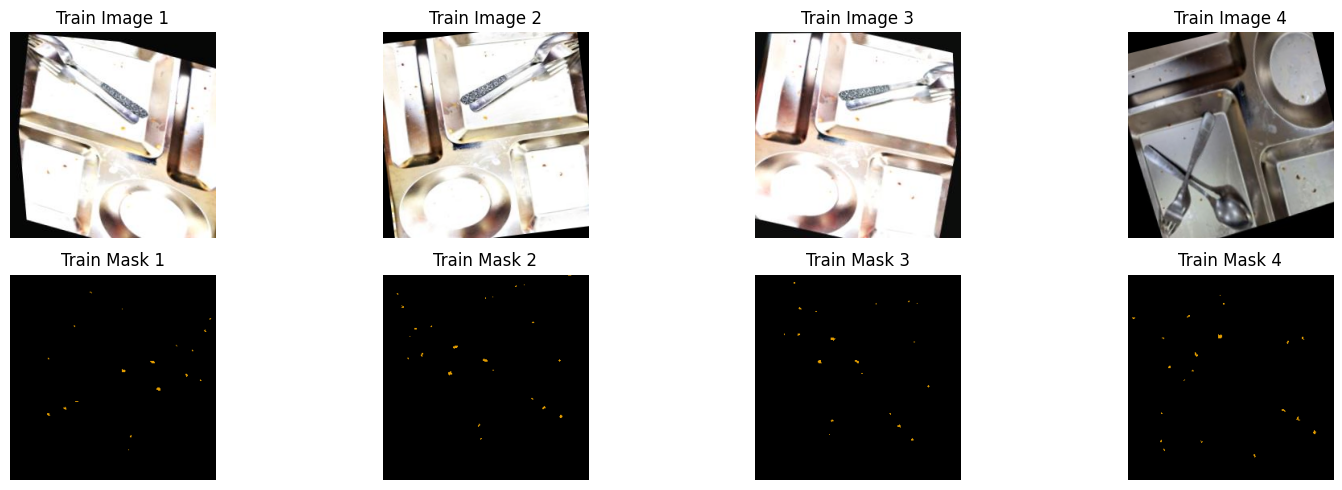

In [ ]:
"""
Cell 11: Visualize a batch from the training set
- Uses unnormalize function and food-specific colormap
- Deterministic batch selection using `next(iter(...))`
"""

import matplotlib.pyplot as plt
import numpy as np
import torch
from matplotlib.colors import ListedColormap

# === Colormap Setup ===
color_palettes = {
    "AdasPolo":         ["#000000", "#E69F00"],
    "CheloGoosht":      ["#000000", "#D55E00", "#F0E442"],
    "Fesenjan":         ["#000000", "#009E73", "#56B4E9"],
    "GheymeBademjan":   ["#000000", "#CC79A7", "#0072B2"],
    "Protein_and_Fries":["#000000", "#E69F00", "#56B4E9"],
}

if selected_category in color_palettes:
    custom_colors = color_palettes[selected_category]
    fixed_cmap = ListedColormap(custom_colors)
else:
    raise ValueError("❌ Unknown category for colormap.")

# === Unnormalize function ===
def unnormalize_image(tensor, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)):
    tensor = tensor.clone()
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

# === Visualize a batch from train_loader ===
images, masks = next(iter(train_loader))

num_samples = min(4, images.size(0))
fig, axs = plt.subplots(2, num_samples, figsize=(4 * num_samples, 5))

for i in range(num_samples):
    img = unnormalize_image(images[i])
    img = img.permute(1, 2, 0).cpu().numpy()
    img = np.clip(img * 255, 0, 255).astype(np.uint8)

    mask = masks[i].squeeze().cpu().numpy()

    axs[0, i].imshow(img)
    axs[0, i].set_title(f"Train Image {i+1}")
    axs[0, i].axis("off")

    axs[1, i].imshow(mask, cmap=fixed_cmap, vmin=0, vmax=len(custom_colors)-1)
    axs[1, i].set_title(f"Train Mask {i+1}")
    axs[1, i].axis("off")

plt.tight_layout()
plt.show()


### Valid batch

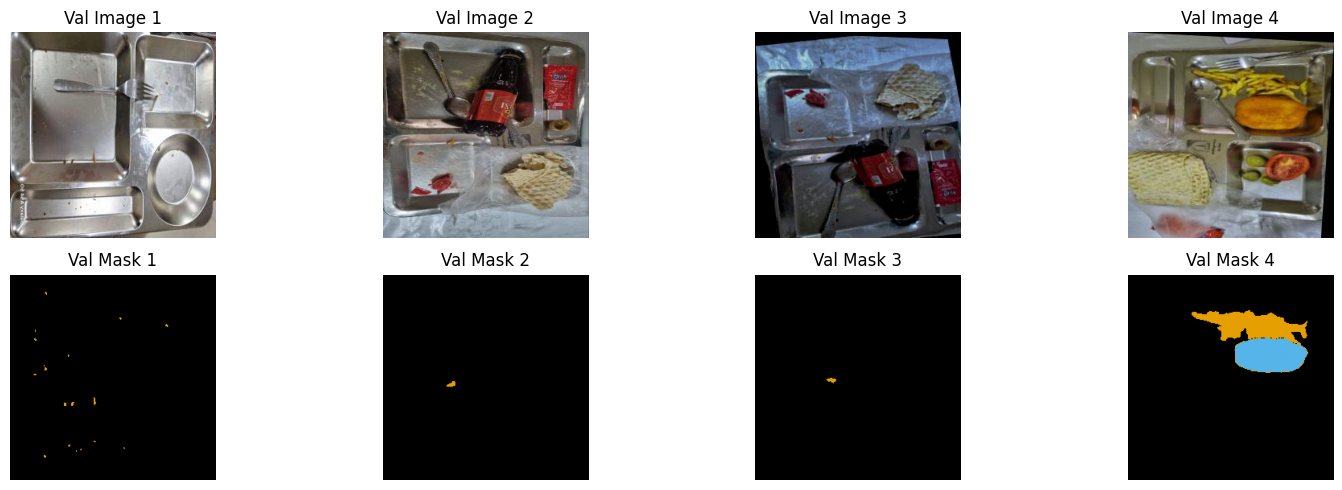

In [ ]:
"""
Cell 12: Visualize a batch from the validation set
- Uses unnormalize function and food-specific colormap
- Deterministic batch selection using `next(iter(...))`
"""

# === Visualize a batch from valid_loader ===
images, masks = next(iter(valid_loader))

num_samples = min(4, images.size(0))
fig, axs = plt.subplots(2, num_samples, figsize=(4 * num_samples, 5))

for i in range(num_samples):
    img = unnormalize_image(images[i])
    img = img.permute(1, 2, 0).cpu().numpy()
    img = np.clip(img * 255, 0, 255).astype(np.uint8)

    mask = masks[i].squeeze().cpu().numpy()

    axs[0, i].imshow(img)
    axs[0, i].set_title(f"Val Image {i+1}")
    axs[0, i].axis("off")

    axs[1, i].imshow(mask, cmap=fixed_cmap, vmin=0, vmax=len(custom_colors)-1)
    axs[1, i].set_title(f"Val Mask {i+1}")
    axs[1, i].axis("off")

plt.tight_layout()
plt.show()


### Test batch

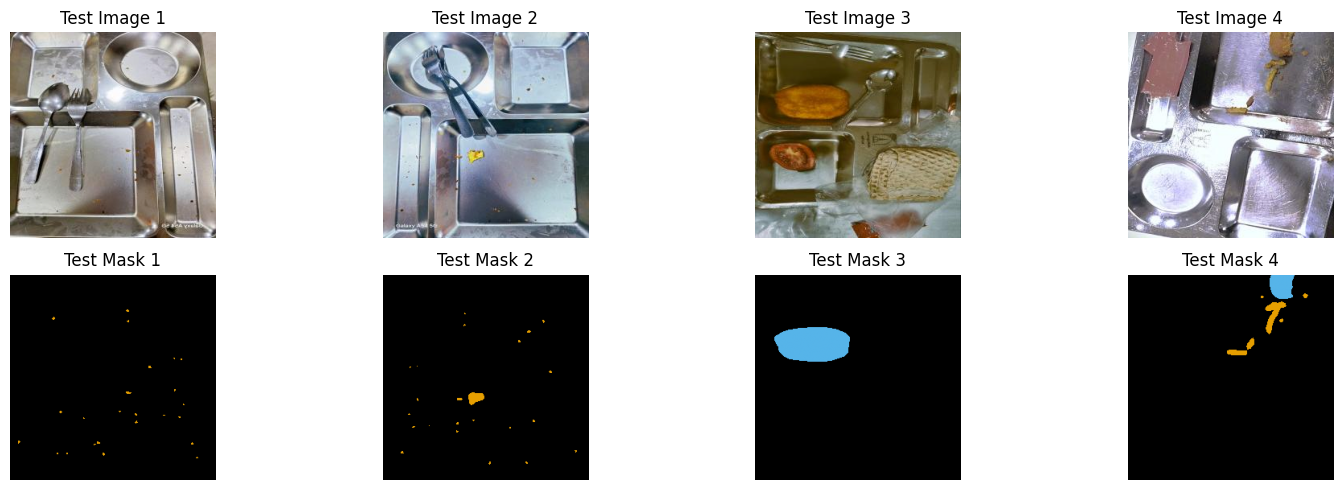

In [ ]:
"""
Cell 13: Visualize a batch from the test set
- Uses unnormalize function and food-specific colormap
- Deterministic batch selection using `next(iter(...))`
"""

# === Visualize a batch from test_loader ===
images, masks = next(iter(test_loader))

num_samples = min(4, images.size(0))
fig, axs = plt.subplots(2, num_samples, figsize=(4 * num_samples, 5))

for i in range(num_samples):
    img = unnormalize_image(images[i])
    img = img.permute(1, 2, 0).cpu().numpy()
    img = np.clip(img * 255, 0, 255).astype(np.uint8)

    mask = masks[i].squeeze().cpu().numpy()

    axs[0, i].imshow(img)
    axs[0, i].set_title(f"Test Image {i+1}")
    axs[0, i].axis("off")

    axs[1, i].imshow(mask, cmap=fixed_cmap, vmin=0, vmax=len(custom_colors)-1)
    axs[1, i].set_title(f"Test Mask {i+1}")
    axs[1, i].axis("off")

plt.tight_layout()
plt.show()


## ✅Final Checking of batches size

In [ ]:
"""
Cell 14: Inspect shape and type of one batch from each loader (train, valid, test)
- Verifies tensor structure for model compatibility
- Uses `next(iter(...))` to ensure repeatable results
"""

import torch

# === Train Loader ===
images, masks = next(iter(train_loader))
print("📦 Train Loader:")
print(f"Images shape:     {images.shape} | type: {type(images)}")
print(f"Masks shape:      {masks.shape}  | type: {type(masks)}")

print("")

# === Validation Loader ===
images, masks = next(iter(valid_loader))
print("📦 Validation Loader:")
print(f"Images shape:     {images.shape} | type: {type(images)}")
print(f"Masks shape:      {masks.shape}  | type: {type(masks)}")

print("")

# === Test Loader ===
images, masks = next(iter(test_loader))
print("📦 Test Loader:")
print(f"Images shape:     {images.shape} | type: {type(images)}")
print(f"Masks shape:      {masks.shape}  | type: {type(masks)}")


📦 Train Loader:
Images shape:     torch.Size([4, 3, 256, 256]) | type: <class 'torch.Tensor'>
Masks shape:      torch.Size([4, 1, 256, 256])  | type: <class 'torch.Tensor'>

📦 Validation Loader:
Images shape:     torch.Size([4, 3, 256, 256]) | type: <class 'torch.Tensor'>
Masks shape:      torch.Size([4, 1, 256, 256])  | type: <class 'torch.Tensor'>

📦 Test Loader:
Images shape:     torch.Size([4, 3, 256, 256]) | type: <class 'torch.Tensor'>
Masks shape:      torch.Size([4, 1, 256, 256])  | type: <class 'torch.Tensor'>


## ⚙️**Device**

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## **🔢 In and Out channels**

In [ ]:
"""
Cell 15: Set in_channels and out_channels based on selected food category
- in_channels is always 3 (RGB)
- out_channels depends on number of mask classes (including background)
"""

# Input always RGB
in_channels = 3

# Output channels based on food category
if selected_category == "AdasPolo":
    out_channels = 2  # Background + AdasPolo
elif selected_category in ["CheloGoosht", "Fesenjan", "GheymeBademjan", "Protein_and_Fries"]:
    out_channels = 3  # Background + 2 foreground classes
else:
    raise ValueError("❌ Unknown food category for setting out_channels.")

print(f"✅ Configuration set:")
print(f"in_channels  = {in_channels}")
print(f"out_channels = {out_channels} (based on {selected_category})")


✅ Configuration set:
in_channels  = 3
out_channels = 3 (based on Protein_and_Fries)


In [ ]:
"""
Cell 15: ✅ Set input/output channels for segmentation based on food category

This cell ensures consistent variable naming across the entire project:
- Input channels are fixed to 3 (RGB), assigned to `in_channels` and `in_channel`
- Output channels depend on the selected food category, and are assigned consistently to:
  `out_channels`, `out_channel`, `num_classes`, and `num_class`
"""

# === Set input channels ===
in_channels = in_channel = 3  # RGB images

# === Set output channels based on food class ===
if selected_category == "AdasPolo":
    out_channels = out_channel = num_classes = num_class = 2  # Background + AdasPolo
elif selected_category in ["CheloGoosht", "Fesenjan", "GheymeBademjan", "Protein_and_Fries"]:
    out_channels = out_channel = num_classes = num_class = 3  # Background + 2 foregrounds
else:
    raise ValueError(f"❌ Unknown food category: {selected_category}")

# === Confirm final config ===
print("✅ Configuration Set")
print(f"in_channels   = {in_channels}")
print(f"in_channel    = {in_channel} ")
print(f"out_channels  = {out_channels}")
print(f"out_channel   = {out_channel}")
print(f"num_classes   = {num_classes}")
print(f"num_class     = {num_class}")
print(f"🔎 Category    = {selected_category}")


✅ Configuration Set
in_channels   = 3
in_channel    = 3 
out_channels  = 3
out_channel   = 3
num_classes   = 3
num_class     = 3
🔎 Category    = Protein_and_Fries


## **🧠MODELS🧠**

### **🔷Original Unet [64,128,256,512,1024]**

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [ ]:
#                                                             PyTorch version
# =====================================================================================================================================================
# =====================================================================================================================================================
import torch
import torch.nn as nn

class UNet(nn.Module):

    # ==========================================================================
    def __init__(self, in_channels=None, out_channels=None):
        super(UNet, self).__init__()

        # =======================================
        # Original Unet proposed in => https://arxiv.org/pdf/1505.04597
        filters_model = [64, 128, 256, 512, 1024]
        # =======================================

        # Encoder                                                                                          # This is the down part, known as contracting path
        self.encoder1 = self.conv_block(in_channels, filters_model[0])                                     # Encoder 1 - should have 64 channels
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)                                                 # Pooling 1

        self.encoder2 = self.conv_block(filters_model[0], filters_model[1])                                # Encoder 2 - should have 128 channels
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)                                                 # Pooling 2

        self.encoder3 = self.conv_block(filters_model[1], filters_model[2])                                # Encoder 3 - should have 256 channels
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)                                                 # Pooling 3

        self.encoder4 = self.conv_block(filters_model[2], filters_model[3])                                # Encoder 4 - should have 512 channels
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)                                                 # Pooling 4

        # Bottleneck
        self.bottleneck = self.conv_block(filters_model[3], filters_model[4])                              # The original Unet => bottleneck should have 1024 channels

        # Decoder
        self.upconv4 = nn.ConvTranspose2d(filters_model[4], filters_model[3], kernel_size=2, stride=2)     # Upconv / TransposConv
        self.decoder4 = self.conv_block(filters_model[4], filters_model[3])                                # Decoder 4

        self.upconv3 = nn.ConvTranspose2d(filters_model[3], filters_model[2], kernel_size=2, stride=2)     # Upconv / TransposConv
        self.decoder3 = self.conv_block(filters_model[3], filters_model[2])                                # Decoder 3

        self.upconv2 = nn.ConvTranspose2d(filters_model[2], filters_model[1], kernel_size=2, stride=2)     # Upconv / TransposConv
        self.decoder2 = self.conv_block(filters_model[2], filters_model[1])                                # Decoder 2

        self.upconv1 = nn.ConvTranspose2d(filters_model[1], filters_model[0], kernel_size=2, stride=2)     # Upconv / TransposConv
        self.decoder1 = self.conv_block(filters_model[1], filters_model[0])                                # Decoder 1

        # Final Convolution
        self.conv = nn.Conv2d(filters_model[0], out_channels, kernel_size=1)                               # Final Conv (converting to out_channels)
    # ==========================================================================



    # Conv block
    # ==========================================================================
    def conv_block(self, in_channels, out_channels):                            # This "conv_block" is a base of the encoders/decoders written at the top
        return nn.Sequential(
                            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                            nn.BatchNorm2d(out_channels),
                            nn.ReLU(inplace=True),
                            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
                            nn.BatchNorm2d(out_channels),
                            nn.ReLU(inplace=True),
                            )                                                   # Can be used both as encoder and decoder
    # ==========================================================================




    # ==========================================================================
    def forward(self, x):
        # Encoder path
        enc1 = self.encoder1(x)
        enc1_pool = self.pool1(enc1)

        enc2 = self.encoder2(enc1_pool)
        enc2_pool = self.pool2(enc2)

        enc3 = self.encoder3(enc2_pool)
        enc3_pool = self.pool3(enc3)

        enc4 = self.encoder4(enc3_pool)
        enc4_pool = self.pool4(enc4)

        # Bottleneck
        bottleneck = self.bottleneck(enc4_pool)

        # Decoder path
        dec4 = self.upconv4(bottleneck)
        dec4_cat = torch.cat((dec4, enc4), dim=1)                               # Skip connection (dim=1 means concatenate them from channels)
        dec4_out = self.decoder4(dec4_cat)

        dec3 = self.upconv3(dec4_out)
        dec3_cat = torch.cat((dec3, enc3), dim=1)                               # Skip connection (dim=1 means concatenate them from channels)
        dec3_out = self.decoder3(dec3_cat)

        dec2 = self.upconv2(dec3_out)
        dec2_cat = torch.cat((dec2, enc2), dim=1)                               # Skip connection (dim=1 means concatenate them from channels)
        dec2_out = self.decoder2(dec2_cat)

        dec1 = self.upconv1(dec2_out)
        dec1_cat = torch.cat((dec1, enc1), dim=1)                               # Skip connection (dim=1 means concatenate them from channels)
        dec1_out = self.decoder1(dec1_cat)

        return self.conv(dec1_out)
    # ==========================================================================

In [ ]:
if __name__ == "__main__":
    model = UNet(in_channels, out_channels)                                     # RGB input and binary output
# ==============================================================================
# Calculate total and trainable parameters
total_params     = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

# Convert to millions
total_params_millions = total_params         / 1_000_000
trainable_params_millions = trainable_params / 1_000_000

# Print results
print("================================================================")
print("================================================================")
print(f"Total Parameters:        {total_params_millions}        million")
print(f"Trainable Parameters:    {trainable_params_millions}    million")

Total Parameters:        31.043651        million
Trainable Parameters:    31.043651    million


In [ ]:
# Checking in and out channels for consistency

print(f"in channels and out channels are {in_channels}, and {out_channels} respectively")

in channels and out channels are 3, and 3 respectively


A simple check. We will make it comment later!

In [ ]:
# # Example of how to create an instance of the U-Net model
# # ========================================================================================================
# if __name__ == "__main__":
#     model = UNet(in_channels=in_channels, out_channels=out_channels)            # RGB input and binary output => out_channels
#     # print(model)                                                                # Print the model architecture


# # Example input tensor
# # ========================================================================================================
# print(f"Image size is: {image_size}")
# print("")
# x_example = torch.randn(4, 3, image_size , image_size)                          # The first number is the Batch Size
# output_example = model(x_example)
# print(f"Output shape: {output_example.shape}")                                  # 4*out_channel*image_size*image_size is expected

### **🔷Smaller Unet  [32,64,128,256,512]**

Smaller Unet [32,64,128,256,512 instead of 64,128,256,512,1024]

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
import torch
import torch.nn as nn

class SmallerUNet(nn.Module):
    def __init__(self, in_channels=None, out_channels=None):
        super(SmallerUNet, self).__init__()

        # Smaller U-Net architecture (halved filters from original U-Net)
        filters_model = [32, 64, 128, 256, 512]                                  # [32,64,128,256,512] instead of [64,128,526,512, and 1024]

        # Encoder (contracting path)
        self.encoder1 = self.conv_block(in_channels, filters_model[0])
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.encoder2 = self.conv_block(filters_model[0], filters_model[1])
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.encoder3 = self.conv_block(filters_model[1], filters_model[2])
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.encoder4 = self.conv_block(filters_model[2], filters_model[3])
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Bottleneck
        self.bottleneck = self.conv_block(filters_model[3], filters_model[4])

        # Decoder (expanding path)
        self.upconv4 = nn.ConvTranspose2d(filters_model[4], filters_model[3], kernel_size=2, stride=2)
        self.decoder4 = self.conv_block(filters_model[4], filters_model[3])

        self.upconv3 = nn.ConvTranspose2d(filters_model[3], filters_model[2], kernel_size=2, stride=2)
        self.decoder3 = self.conv_block(filters_model[3], filters_model[2])

        self.upconv2 = nn.ConvTranspose2d(filters_model[2], filters_model[1], kernel_size=2, stride=2)
        self.decoder2 = self.conv_block(filters_model[2], filters_model[1])

        self.upconv1 = nn.ConvTranspose2d(filters_model[1], filters_model[0], kernel_size=2, stride=2)
        self.decoder1 = self.conv_block(filters_model[1], filters_model[0])

        # Final classifier
        self.conv = nn.Conv2d(filters_model[0], out_channels, kernel_size=1)

    # Shared conv block for encoder/decoder
    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        # Encoder
        enc1 = self.encoder1(x)
        enc1_pool = self.pool1(enc1)

        enc2 = self.encoder2(enc1_pool)
        enc2_pool = self.pool2(enc2)

        enc3 = self.encoder3(enc2_pool)
        enc3_pool = self.pool3(enc3)

        enc4 = self.encoder4(enc3_pool)
        enc4_pool = self.pool4(enc4)

        # Bottleneck
        bottleneck = self.bottleneck(enc4_pool)

        # Decoder
        dec4 = self.upconv4(bottleneck)
        dec4_cat = torch.cat((dec4, enc4), dim=1)
        dec4_out = self.decoder4(dec4_cat)

        dec3 = self.upconv3(dec4_out)
        dec3_cat = torch.cat((dec3, enc3), dim=1)
        dec3_out = self.decoder3(dec3_cat)

        dec2 = self.upconv2(dec3_out)
        dec2_cat = torch.cat((dec2, enc2), dim=1)
        dec2_out = self.decoder2(dec2_cat)

        dec1 = self.upconv1(dec2_out)
        dec1_cat = torch.cat((dec1, enc1), dim=1)
        dec1_out = self.decoder1(dec1_cat)

        return self.conv(dec1_out)

In [ ]:
#                                 PyTorch version
# ==============================================================================

if __name__ == "__main__":
    model = SmallerUNet(in_channels, out_channels)                                     # RGB input and binary output
# ==============================================================================
# Calculate total and trainable parameters
total_params     = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

# Convert to millions
total_params_millions = total_params         / 1_000_000
trainable_params_millions = trainable_params / 1_000_000

# Print results
print("================================================================")
print("================================================================")
print(f"Total Parameters:        {total_params_millions}        million")
print(f"Trainable Parameters:    {trainable_params_millions}    million")

Total Parameters:        7.766051        million
Trainable Parameters:    7.766051    million


In [ ]:
# Checking in and out channels for consistency

print(f"in channels and out channels are {in_channels}, and {out_channels} respectively")

in channels and out channels are 3, and 3 respectively


The next cell is a simple check and will be made commment later!

In [ ]:
# # Example of how to create an instance of the U-Net model
# # ========================================================================================================
# if __name__ == "__main__":
#     model = SmallerUNet(in_channels=in_channels, out_channels=out_channels)       # RGB input and binary output => out_channels
#     # print(model)                                                                # Print the model architecture


# # Example input tensor
# # ========================================================================================================
# print(f"Image size is: {image_size}")
# print("")
# x_example = torch.randn(4, 3, image_size , image_size)                          # The first number is the Batch Size
# output_example = model(x_example)
# print(f"Output shape: {output_example.shape}")                                  # 4*out_channel*image_size*image_size is expected

### **🔷NestNet [64,128,256,512,1024]**

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [ ]:
#                         CLASS & Based on PyTorch (OK)
# ==============================================================================
import torch
import torch.nn as nn
import torch.nn.functional as F

# Define the NestNet class
class NestNet(nn.Module):
    def __init__(self, in_channels=None, out_channels=None):

        super(NestNet, self).__init__()
        # Initialize parameters for the network
        self.in_channels  = in_channels
        self.out_channels = out_channels

        # Better version
        self.nb_filter = [64, 128, 256, 512, 1024]
        # LESS version
        # self.nb_filter = [32, 64, 128, 256, 512]

        # Define layers
        # Contracting path layers
        self.conv1_1 = self.standard_pool_unit(self.in_channels, self.nb_filter[0])
        self.conv2_1 = self.standard_pool_unit(self.nb_filter[0], self.nb_filter[1])
        self.conv3_1 = self.standard_pool_unit(self.nb_filter[1], self.nb_filter[2])
        self.conv4_1 = self.standard_pool_unit(self.nb_filter[2], self.nb_filter[3])
        self.conv5_1 = self.standard_unit(self.nb_filter[3], self.nb_filter[4])

        # Nested blocks
        self.conv1_2 = self.standard_unit(self.nb_filter[0] * 2, self.nb_filter[0])
        self.conv2_2 = self.standard_unit(self.nb_filter[1] * 2, self.nb_filter[1])
        self.conv1_3 = self.standard_unit(self.nb_filter[0] * 3, self.nb_filter[0])
        self.conv3_2 = self.standard_unit(self.nb_filter[2] * 2, self.nb_filter[2])
        self.conv2_3 = self.standard_unit(self.nb_filter[1] * 3, self.nb_filter[1])
        self.conv1_4 = self.standard_unit(self.nb_filter[0] * 4, self.nb_filter[0])
        self.conv4_2 = self.standard_unit(self.nb_filter[3] * 2, self.nb_filter[3])
        self.conv3_3 = self.standard_unit(self.nb_filter[2] * 3, self.nb_filter[2])
        self.conv2_4 = self.standard_unit(self.nb_filter[1] * 4, self.nb_filter[1])
        self.conv1_5 = self.standard_unit(self.nb_filter[0] * 5, self.nb_filter[0])

        # Transpose convolution (upsampling)
        self.up1_2 = nn.ConvTranspose2d(self.nb_filter[1], self.nb_filter[0], kernel_size=2, stride=2)
        self.up1_3 = nn.ConvTranspose2d(self.nb_filter[1], self.nb_filter[0], kernel_size=2, stride=2)
        self.up2_2 = nn.ConvTranspose2d(self.nb_filter[2], self.nb_filter[1], kernel_size=2, stride=2)
        self.up2_3 = nn.ConvTranspose2d(self.nb_filter[2], self.nb_filter[1], kernel_size=2, stride=2)
        self.up2_4 = nn.ConvTranspose2d(self.nb_filter[2], self.nb_filter[1], kernel_size=2, stride=2)
        self.up3_2 = nn.ConvTranspose2d(self.nb_filter[3], self.nb_filter[2], kernel_size=2, stride=2)
        self.up3_3 = nn.ConvTranspose2d(self.nb_filter[3], self.nb_filter[2], kernel_size=2, stride=2)
        self.up4_2 = nn.ConvTranspose2d(self.nb_filter[4], self.nb_filter[3], kernel_size=2, stride=2)
        self.up1_4 = nn.ConvTranspose2d(self.nb_filter[1], self.nb_filter[0], kernel_size=2, stride=2)
        self.up1_5 = nn.ConvTranspose2d(self.nb_filter[1], self.nb_filter[0], kernel_size=2, stride=2)

        # Output layer
        self.output_layer = nn.Conv2d(self.nb_filter[0], self.out_channels, kernel_size=1, padding=0)

    # ===============================================================================================
    def standard_pool_unit(self, in_channels, out_channels, kernel_size=3):
        act = nn.ReLU(inplace=True)
        layers = [
                  nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=1, bias=False),
                  nn.BatchNorm2d(out_channels),
                  act,
                  nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, padding=1, bias=False),
                  nn.BatchNorm2d(out_channels),
                  act
                  ]
        return nn.Sequential(*layers)

    def standard_unit(self, in_channels, out_channels, kernel_size=3):
        act = nn.ReLU(inplace=True)
        layers = [
                  nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=1, bias=False),
                  act,
                  nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, padding=1, bias=False),
                  act
                  ]
        return nn.Sequential(*layers)
    # ================================================================================================


    def forward(self, x):
        # Contracting path (going down) + Creating nested blocks
        # ======================================================
        # Block 1*1
        conv1_1 = self.conv1_1(x)
        pool1 = F.max_pool2d(conv1_1, kernel_size=2)

        # Block 2*1
        conv2_1 = self.conv2_1(pool1)
        pool2 = F.max_pool2d(conv2_1, kernel_size=2)

        # Block 1*2
        up1_2 = self.up1_2(conv2_1)
        conv1_2 = torch.cat([up1_2, conv1_1], dim=1)
        conv1_2 = self.conv1_2(conv1_2)

        # Block 3*1
        conv3_1 = self.conv3_1(pool2)
        pool3 = F.max_pool2d(conv3_1, kernel_size=2)

        # Block 2*2
        up2_2 = self.up2_2(conv3_1)
        conv2_2 = torch.cat([up2_2, conv2_1], dim=1)
        conv2_2 = self.conv2_2(conv2_2)

        # Block 1*3
        up1_3 = self.up1_3(conv2_2)
        conv1_3 = torch.cat([up1_3, conv1_1, conv1_2], dim=1)
        conv1_3 = self.conv1_3(conv1_3)

        # Block 4*1
        conv4_1 = self.conv4_1(pool3)
        drop4 = F.dropout(conv4_1, p=0.5, training=self.training)
        pool4 = F.max_pool2d(drop4, kernel_size=2)

        # Block 3*2
        up3_2 = self.up3_2(conv4_1)
        conv3_2 = torch.cat([up3_2, conv3_1], dim=1)
        conv3_2 = self.conv3_2(conv3_2)

        # Block 2*3
        up2_3 = self.up2_3(conv3_2)
        conv2_3 = torch.cat([up2_3, conv2_1, conv2_2], dim=1)
        conv2_3 = self.conv2_3(conv2_3)

        # Block 1*4
        up1_4 = self.up1_4(conv2_3)
        conv1_4 = torch.cat([up1_4, conv1_1, conv1_2, conv1_3], dim=1)
        conv1_4 = self.conv1_4(conv1_4)

        # Block 5*1 => Bottleneck
        conv5_1 = self.conv5_1(pool4)
        conv5_1 = F.dropout(conv5_1, p=0.5, training=self.training)

        # Upconv / Decoder / going up + Nested blocks
        # ======================================================
        # Block 4*2
        up4_2 = self.up4_2(conv5_1)
        conv4_2 = torch.cat([up4_2, conv4_1], dim=1)
        conv4_2 = self.conv4_2(conv4_2)

        # Block 3*3
        up3_3 = self.up3_3(conv4_2)
        conv3_3 = torch.cat([up3_3, conv3_1, conv3_2], dim=1)
        conv3_3 = self.conv3_3(conv3_3)

        # Block 2*4
        up2_4 = self.up2_4(conv3_3)
        conv2_4 = torch.cat([up2_4, conv2_1, conv2_2, conv2_3], dim=1)
        conv2_4 = self.conv2_4(conv2_4)

        # Block 1*5
        up1_5 = self.up1_5(conv2_4)
        conv1_5 = torch.cat([up1_5, conv1_1, conv1_2, conv1_3, conv1_4], dim=1)
        conv1_5 = self.conv1_5(conv1_5)

        # Output layer
        output = self.output_layer(conv1_5)
        return output

In [ ]:
#                                 PyTorch version
# ==============================================================================

if __name__ == "__main__":
    model = NestNet(in_channels, out_channels)                                     # RGB input and binary output
# ==============================================================================
# Calculate total and trainable parameters
total_params     = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

# Convert to millions
total_params_millions = total_params         / 1_000_000
trainable_params_millions = trainable_params / 1_000_000

# Print results
print("================================================================")
print("================================================================")
print(f"Total Parameters:        {total_params_millions}        million")
print(f"Trainable Parameters:    {trainable_params_millions}    million")

Total Parameters:        36.154627        million
Trainable Parameters:    36.154627    million


In [ ]:
# Checking in and out channels for consistency

print(f"in channels and out channels are {in_channels}, and {out_channels} respectively")

in channels and out channels are 3, and 3 respectively


The next cell is an in-depth check section of the NestNet model. Please make it comment after checking that all is right

In [ ]:
# # The follwing code is only and only designed for an in-depth check. If you run that, comment it again, then run the notebook from the ground up


# # Assuming the class definition for NestNet is already defined and imported as per your code above

# # Create a sample input tensor
# image_like_tensor_for_example = torch.randn(1, 3, 64, 64)  # [batch_size, channels, height, width]

# # Instantiate the model
# model = NestNet(in_channels=in_channels, out_channels=out_channels)  # Adjust output channels as needed

# # Update the forward function to include shape printing
# def modified_forward(self, x):
#     # Contracting path (going down) + Creating nested blocks
#     # ======================================================
#     print("Input shape:", x.shape)
#     print("")
#     # Block 1*1
#     conv1_1 = self.conv1_1(x)
#     print("After conv1_1:", conv1_1.shape)
#     pool1 = F.max_pool2d(conv1_1, kernel_size=2)
#     print("After pool1:", pool1.shape)
#     print("")
#     # Block 2*1
#     conv2_1 = self.conv2_1(pool1)
#     print("After conv2_1:", conv2_1.shape)
#     pool2 = F.max_pool2d(conv2_1, kernel_size=2)
#     print("After pool2:", pool2.shape)
#     print("")
#     # Block 1*2
#     up1_2 = self.up1_2(conv2_1)
#     print("After up1_2:", up1_2.shape)
#     conv1_2 = torch.cat([up1_2, conv1_1], dim=1)
#     print("After concat conv1_2:", conv1_2.shape)
#     conv1_2 = self.conv1_2(conv1_2)
#     print("After conv1_2:", conv1_2.shape)
#     print("")
#     # Block 3*1
#     conv3_1 = self.conv3_1(pool2)
#     print("After conv3_1:", conv3_1.shape)
#     pool3 = F.max_pool2d(conv3_1, kernel_size=2)
#     print("After pool3:", pool3.shape)
#     print("")
#     # Block 2*2
#     up2_2 = self.up2_2(conv3_1)
#     print("After up2_2:", up2_2.shape)
#     conv2_2 = torch.cat([up2_2, conv2_1], dim=1)
#     print("After concat conv2_2:", conv2_2.shape)
#     conv2_2 = self.conv2_2(conv2_2)
#     print("After conv2_2:", conv2_2.shape)
#     print("")
#     # Block 1*3
#     up1_3 = self.up1_3(conv2_2)
#     print("After up1_3:", up1_3.shape)
#     conv1_3 = torch.cat([up1_3, conv1_1, conv1_2], dim=1)
#     print("After concat conv1_3:", conv1_3.shape)
#     conv1_3 = self.conv1_3(conv1_3)
#     print("After conv1_3:", conv1_3.shape)
#     print("")
#     # Block 4*1
#     conv4_1 = self.conv4_1(pool3)
#     print("After conv4_1:", conv4_1.shape)
#     drop4 = F.dropout(conv4_1, p=0.5, training=self.training)
#     print("After dropout drop4:", drop4.shape)
#     pool4 = F.max_pool2d(drop4, kernel_size=2)
#     print("After pool4:", pool4.shape)
#     print("")
#     # Block 3*2
#     up3_2 = self.up3_2(conv4_1)
#     print("After up3_2:", up3_2.shape)
#     conv3_2 = torch.cat([up3_2, conv3_1], dim=1)
#     print("After concat conv3_2:", conv3_2.shape)
#     conv3_2 = self.conv3_2(conv3_2)
#     print("After conv3_2:", conv3_2.shape)
#     print("")
#     # Block 2*3
#     up2_3 = self.up2_3(conv3_2)
#     print("After up2_3:", up2_3.shape)
#     conv2_3 = torch.cat([up2_3, conv2_1, conv2_2], dim=1)
#     print("After concat conv2_3:", conv2_3.shape)
#     conv2_3 = self.conv2_3(conv2_3)
#     print("After conv2_3:", conv2_3.shape)
#     print("")
#     # Block 1*4
#     up1_4 = self.up1_4(conv2_3)
#     print("After up1_4:", up1_4.shape)
#     conv1_4 = torch.cat([up1_4, conv1_1, conv1_2, conv1_3], dim=1)
#     print("After concat conv1_4:", conv1_4.shape)
#     conv1_4 = self.conv1_4(conv1_4)
#     print("After conv1_4:", conv1_4.shape)
#     print("")
#     # Block 5*1 => Bottleneck
#     conv5_1 = self.conv5_1(pool4)
#     print("After conv5_1:", conv5_1.shape)
#     conv5_1 = F.dropout(conv5_1, p=0.5, training=self.training)
#     print("After dropout conv5_1:", conv5_1.shape)
#     print("")
#     # Upconv / Decoder / going up + Nested blocks
#     # ======================================================
#     # Block 4*2
#     up4_2 = self.up4_2(conv5_1)
#     print("After up4_2:", up4_2.shape)
#     conv4_2 = torch.cat([up4_2, conv4_1], dim=1)
#     print("After concat conv4_2:", conv4_2.shape)
#     conv4_2 = self.conv4_2(conv4_2)
#     print("After conv4_2:", conv4_2.shape)
#     print("")
#     # Block 3*3
#     up3_3 = self.up3_3(conv4_2)
#     print("After up3_3:", up3_3.shape)
#     conv3_3 = torch.cat([up3_3, conv3_1, conv3_2], dim=1)
#     print("After concat conv3_3:", conv3_3.shape)
#     conv3_3 = self.conv3_3(conv3_3)
#     print("After conv3_3:", conv3_3.shape)
#     print("")
#     # Block 2*4
#     up2_4 = self.up2_4(conv3_3)
#     print("After up2_4:", up2_4.shape)
#     conv2_4 = torch.cat([up2_4, conv2_1, conv2_2, conv2_3], dim=1)
#     print("After concat conv2_4:", conv2_4.shape)
#     conv2_4 = self.conv2_4(conv2_4)
#     print("After conv2_4:", conv2_4.shape)
#     print("")
#     # Block 1*5
#     up1_5 = self.up1_5(conv2_4)
#     print("After up1_5:", up1_5.shape)
#     conv1_5 = torch.cat([up1_5, conv1_1, conv1_2, conv1_3, conv1_4], dim=1)
#     print("After concat conv1_5:", conv1_5.shape)
#     conv1_5 = self.conv1_5(conv1_5)
#     print("After conv1_5:", conv1_5.shape)
#     print("")
#     # Output layer
#     output = self.output_layer(conv1_5)
#     print("After output layer:", output.shape)
#     return output
#     print("")

# # Bind the modified forward function to our model
# model.forward = modified_forward.__get__(model, NestNet)

# # Run the model with the sample input
# output = model(image_like_tensor_for_example)


### **🔷Smaller NestNet [32,64,128,256,512]**

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Define the Smaller_NestNet class (Lightweight U-Net++)
class Smaller_NestNet(nn.Module):
    def __init__(self, in_channels=None, out_channels=None):
        super(Smaller_NestNet, self).__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels

        # Lightweight version with fewer filters
        self.nb_filter = [32, 64, 128, 256, 512]

        # Contracting path (encoder)
        self.conv1_1 = self.standard_pool_unit(self.in_channels, self.nb_filter[0])
        self.conv2_1 = self.standard_pool_unit(self.nb_filter[0], self.nb_filter[1])
        self.conv3_1 = self.standard_pool_unit(self.nb_filter[1], self.nb_filter[2])
        self.conv4_1 = self.standard_pool_unit(self.nb_filter[2], self.nb_filter[3])
        self.conv5_1 = self.standard_unit(self.nb_filter[3], self.nb_filter[4])  # bottleneck

        # Nested decoder blocks
        self.conv1_2 = self.standard_unit(self.nb_filter[0] * 2, self.nb_filter[0])
        self.conv2_2 = self.standard_unit(self.nb_filter[1] * 2, self.nb_filter[1])
        self.conv1_3 = self.standard_unit(self.nb_filter[0] * 3, self.nb_filter[0])
        self.conv3_2 = self.standard_unit(self.nb_filter[2] * 2, self.nb_filter[2])
        self.conv2_3 = self.standard_unit(self.nb_filter[1] * 3, self.nb_filter[1])
        self.conv1_4 = self.standard_unit(self.nb_filter[0] * 4, self.nb_filter[0])
        self.conv4_2 = self.standard_unit(self.nb_filter[3] * 2, self.nb_filter[3])
        self.conv3_3 = self.standard_unit(self.nb_filter[2] * 3, self.nb_filter[2])
        self.conv2_4 = self.standard_unit(self.nb_filter[1] * 4, self.nb_filter[1])
        self.conv1_5 = self.standard_unit(self.nb_filter[0] * 5, self.nb_filter[0])

        # Upsampling blocks
        self.up1_2 = nn.ConvTranspose2d(self.nb_filter[1], self.nb_filter[0], kernel_size=2, stride=2)
        self.up1_3 = nn.ConvTranspose2d(self.nb_filter[1], self.nb_filter[0], kernel_size=2, stride=2)
        self.up1_4 = nn.ConvTranspose2d(self.nb_filter[1], self.nb_filter[0], kernel_size=2, stride=2)
        self.up1_5 = nn.ConvTranspose2d(self.nb_filter[1], self.nb_filter[0], kernel_size=2, stride=2)

        self.up2_2 = nn.ConvTranspose2d(self.nb_filter[2], self.nb_filter[1], kernel_size=2, stride=2)
        self.up2_3 = nn.ConvTranspose2d(self.nb_filter[2], self.nb_filter[1], kernel_size=2, stride=2)
        self.up2_4 = nn.ConvTranspose2d(self.nb_filter[2], self.nb_filter[1], kernel_size=2, stride=2)

        self.up3_2 = nn.ConvTranspose2d(self.nb_filter[3], self.nb_filter[2], kernel_size=2, stride=2)
        self.up3_3 = nn.ConvTranspose2d(self.nb_filter[3], self.nb_filter[2], kernel_size=2, stride=2)

        self.up4_2 = nn.ConvTranspose2d(self.nb_filter[4], self.nb_filter[3], kernel_size=2, stride=2)

        # Final output layer
        self.output_layer = nn.Conv2d(self.nb_filter[0], self.out_channels, kernel_size=1, padding=0)

    # Standard encoder block
    def standard_pool_unit(self, in_channels, out_channels, kernel_size=3):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    # Standard decoder block
    def standard_unit(self, in_channels, out_channels, kernel_size=3):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=1, bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, padding=1, bias=False),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # Encoder
        conv1_1 = self.conv1_1(x)
        pool1 = F.max_pool2d(conv1_1, kernel_size=2)

        conv2_1 = self.conv2_1(pool1)
        pool2 = F.max_pool2d(conv2_1, kernel_size=2)

        up1_2 = self.up1_2(conv2_1)
        conv1_2 = self.conv1_2(torch.cat([up1_2, conv1_1], dim=1))

        conv3_1 = self.conv3_1(pool2)
        pool3 = F.max_pool2d(conv3_1, kernel_size=2)

        up2_2 = self.up2_2(conv3_1)
        conv2_2 = self.conv2_2(torch.cat([up2_2, conv2_1], dim=1))

        up1_3 = self.up1_3(conv2_2)
        conv1_3 = self.conv1_3(torch.cat([up1_3, conv1_1, conv1_2], dim=1))

        conv4_1 = self.conv4_1(pool3)
        drop4 = F.dropout(conv4_1, p=0.5, training=self.training)
        pool4 = F.max_pool2d(drop4, kernel_size=2)

        up3_2 = self.up3_2(conv4_1)
        conv3_2 = self.conv3_2(torch.cat([up3_2, conv3_1], dim=1))

        up2_3 = self.up2_3(conv3_2)
        conv2_3 = self.conv2_3(torch.cat([up2_3, conv2_1, conv2_2], dim=1))

        up1_4 = self.up1_4(conv2_3)
        conv1_4 = self.conv1_4(torch.cat([up1_4, conv1_1, conv1_2, conv1_3], dim=1))

        conv5_1 = self.conv5_1(pool4)
        conv5_1 = F.dropout(conv5_1, p=0.5, training=self.training)

        up4_2 = self.up4_2(conv5_1)
        conv4_2 = self.conv4_2(torch.cat([up4_2, conv4_1], dim=1))

        up3_3 = self.up3_3(conv4_2)
        conv3_3 = self.conv3_3(torch.cat([up3_3, conv3_1, conv3_2], dim=1))

        up2_4 = self.up2_4(conv3_3)
        conv2_4 = self.conv2_4(torch.cat([up2_4, conv2_1, conv2_2, conv2_3], dim=1))

        up1_5 = self.up1_5(conv2_4)
        conv1_5 = self.conv1_5(torch.cat([up1_5, conv1_1, conv1_2, conv1_3, conv1_4], dim=1))

        return self.output_layer(conv1_5)


In [ ]:
#                                 PyTorch version
# ==============================================================================

if __name__ == "__main__":
    model = Smaller_NestNet(in_channels, out_channels)                                     # RGB input and binary output
# ==============================================================================
# Calculate total and trainable parameters
total_params     = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

# Convert to millions
total_params_millions = total_params         / 1_000_000
trainable_params_millions = trainable_params / 1_000_000

# Print results
print("================================================================")
print("================================================================")
print(f"Total Parameters:        {total_params_millions}        million")
print(f"Trainable Parameters:    {trainable_params_millions}    million")

Total Parameters:        9.040515        million
Trainable Parameters:    9.040515    million


In [ ]:
# Checking in and out channels for consistency

print(f"in channels and out channels are {in_channels}, and {out_channels} respectively")

in channels and out channels are 3, and 3 respectively


The next cell is an in-depth check of Smaller Unet. Make it comment after running

In [ ]:
# import torch
# import torch.nn.functional as F

# # Parameters
# in_channels = 3
# out_channels = 15

# # Dummy input
# image_like_tensor_for_example = torch.randn(1, in_channels, 64, 64)

# # Instantiate the model
# model = Smaller_NestNet(in_channels=in_channels, out_channels=out_channels)

# # Modified forward function to inspect shapes
# def modified_forward(self, x):
#     print("Input shape:", x.shape, "\n")

#     conv1_1 = self.conv1_1(x)
#     print("conv1_1:", conv1_1.shape)
#     pool1 = F.max_pool2d(conv1_1, 2)
#     print("pool1:", pool1.shape, "\n")

#     conv2_1 = self.conv2_1(pool1)
#     print("conv2_1:", conv2_1.shape)
#     pool2 = F.max_pool2d(conv2_1, 2)
#     print("pool2:", pool2.shape, "\n")

#     up1_2 = self.up1_2(conv2_1)
#     print("up1_2:", up1_2.shape)
#     conv1_2 = self.conv1_2(torch.cat([up1_2, conv1_1], dim=1))
#     print("conv1_2:", conv1_2.shape, "\n")

#     conv3_1 = self.conv3_1(pool2)
#     print("conv3_1:", conv3_1.shape)
#     pool3 = F.max_pool2d(conv3_1, 2)
#     print("pool3:", pool3.shape, "\n")

#     up2_2 = self.up2_2(conv3_1)
#     print("up2_2:", up2_2.shape)
#     conv2_2 = self.conv2_2(torch.cat([up2_2, conv2_1], dim=1))
#     print("conv2_2:", conv2_2.shape, "\n")

#     up1_3 = self.up1_3(conv2_2)
#     print("up1_3:", up1_3.shape)
#     conv1_3 = self.conv1_3(torch.cat([up1_3, conv1_1, conv1_2], dim=1))
#     print("conv1_3:", conv1_3.shape, "\n")

#     conv4_1 = self.conv4_1(pool3)
#     print("conv4_1:", conv4_1.shape)
#     drop4 = F.dropout(conv4_1, p=0.5, training=self.training)
#     print("drop4:", drop4.shape)
#     pool4 = F.max_pool2d(drop4, 2)
#     print("pool4:", pool4.shape, "\n")

#     up3_2 = self.up3_2(conv4_1)
#     print("up3_2:", up3_2.shape)
#     conv3_2 = self.conv3_2(torch.cat([up3_2, conv3_1], dim=1))
#     print("conv3_2:", conv3_2.shape, "\n")

#     up2_3 = self.up2_3(conv3_2)
#     print("up2_3:", up2_3.shape)
#     conv2_3 = self.conv2_3(torch.cat([up2_3, conv2_1, conv2_2], dim=1))
#     print("conv2_3:", conv2_3.shape, "\n")

#     up1_4 = self.up1_4(conv2_3)
#     print("up1_4:", up1_4.shape)
#     conv1_4 = self.conv1_4(torch.cat([up1_4, conv1_1, conv1_2, conv1_3], dim=1))
#     print("conv1_4:", conv1_4.shape, "\n")

#     conv5_1 = self.conv5_1(pool4)
#     print("conv5_1:", conv5_1.shape)
#     conv5_1 = F.dropout(conv5_1, p=0.5, training=self.training)
#     print("dropout conv5_1:", conv5_1.shape, "\n")

#     up4_2 = self.up4_2(conv5_1)
#     print("up4_2:", up4_2.shape)
#     conv4_2 = self.conv4_2(torch.cat([up4_2, conv4_1], dim=1))
#     print("conv4_2:", conv4_2.shape, "\n")

#     up3_3 = self.up3_3(conv4_2)
#     print("up3_3:", up3_3.shape)
#     conv3_3 = self.conv3_3(torch.cat([up3_3, conv3_1, conv3_2], dim=1))
#     print("conv3_3:", conv3_3.shape, "\n")

#     up2_4 = self.up2_4(conv3_3)
#     print("up2_4:", up2_4.shape)
#     conv2_4 = self.conv2_4(torch.cat([up2_4, conv2_1, conv2_2, conv2_3], dim=1))
#     print("conv2_4:", conv2_4.shape, "\n")

#     up1_5 = self.up1_5(conv2_4)
#     print("up1_5:", up1_5.shape)
#     conv1_5 = self.conv1_5(torch.cat([up1_5, conv1_1, conv1_2, conv1_3, conv1_4], dim=1))
#     print("conv1_5:", conv1_5.shape, "\n")

#     output = self.output_layer(conv1_5)
#     print("🎯 Final Output Shape:", output.shape)
#     return output

# # Bind modified forward for inspection
# model.forward = modified_forward.__get__(model, Smaller_NestNet)

# # Run it
# _ = model(image_like_tensor_for_example)


# _ = model(image_like_tensor_for_example)

# # ↓ Add this after running the model
# print("="*60)
# total_params = sum(p.numel() for p in model.parameters())
# trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
# print("🧠 Total Parameters:     ", total_params)
# print("🛠️ Trainable Parameters:", trainable_params)

## ✅🧠PICK Your MODEL here, more CHECK

These numbers may be approxiamte

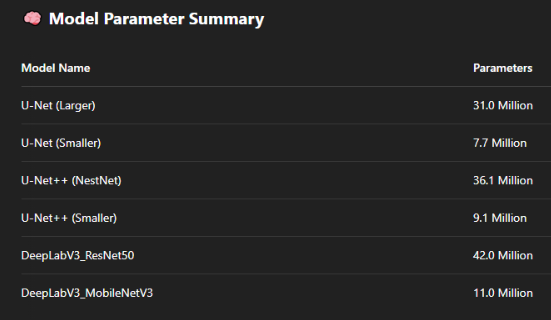

In [ ]:
import torch

# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters()) / 1e6
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad) / 1e6

# Display counts in millions
print(f"🧠 Total Parameters:     {total_params:.2f}M")
print(f"🛠️ Trainable Parameters: {trainable_params:.2f}M")

🧠 Total Parameters:     7.77M
🛠️ Trainable Parameters: 7.77M


## **⚖️LOSS Function(s)**

More Weights for Larger Classes (Not recommended at all as lead to smaller classes to be neglected)

In [ ]:
# """
# This module defines DynamicWeightedCrossEntropy, a custom loss function for
# multi-class semantic segmentation with class imbalance. It computes per-batch
# class weights based on the current ground truth, giving more importance to
# classes with more pixels (e.g., background) to reflect their prevalence in the batch.
# """

# import torch
# import torch.nn as nn
# import torch.nn.functional as F

# class DynamicWeightedCrossEntropy(nn.Module):
#     def __init__(self, num_classes, eps=1e-7):
#         """
#         Args:
#             num_classes (int): Number of output classes (including background)
#             eps (float): Small value to avoid division by zero
#         """
#         super(DynamicWeightedCrossEntropy, self).__init__()
#         self.num_classes = num_classes
#         self.eps = eps

#     def forward(self, preds, targets):
#         """
#         Args:
#             preds (Tensor): Predicted logits of shape [B, C, H, W]
#             targets (Tensor): Ground truth labels of shape [B, H, W] with values in [0, C-1]
#         """
#         B, C, H, W = preds.shape
#         preds = preds.permute(0, 2, 3, 1).reshape(-1, C)  # [B*H*W, C]
#         targets = targets.view(-1)                        # [B*H*W]

#         # Count class occurrences in batch
#         pixel_counts = torch.bincount(targets, minlength=self.num_classes).float()
#         total_pixels = pixel_counts.sum() + self.eps
#         class_weights = pixel_counts / total_pixels       # Normalize to [0, 1]
#         class_weights = class_weights.clamp(min=self.eps)  # Avoid zero weights

#         # Weighted Negative Log-Likelihood loss
#         log_probs = F.log_softmax(preds, dim=1)
#         return F.nll_loss(log_probs, targets, weight=class_weights, reduction='mean')

In [ ]:
# loss_function = DynamicWeightedCrossEntropy(num_classes=out_channels)

Normal Cross Entropy Loss (Not optimal as it treats both small and largers classes the same)

In [ ]:
# loss_function = nn.CrossEntropyLoss()

More Weight for Smaller Classes (Reversed Pixel Weights) [This is good but can explode loss for very small classes, so goo but not optimal!]

In [ ]:
# class DynamicWeightedCELoss(nn.Module):
#     def __init__(self, num_classes):
#         super().__init__()
#         self.num_classes = num_classes

#     def forward(self, inputs, targets):
#         N, C, H, W = inputs.shape
#         with torch.no_grad():
#             one_hot = F.one_hot(targets, num_classes=self.num_classes)
#             one_hot = one_hot.permute(0, 3, 1, 2).float()
#             class_counts = one_hot.sum(dim=(0, 2, 3))
#             total = class_counts.sum()
#             freq = class_counts / total
#             weights = 1.0 / (freq + 1e-6)
#             weights = weights / weights.sum() * self.num_classes

#         inputs = inputs.permute(0, 2, 3, 1).reshape(-1, C)
#         targets = targets.view(-1)
#         loss = F.cross_entropy(inputs, targets, weight=weights)
#         return loss

# loss_function = DynamicWeightedCELoss(num_classes=num_classes)

More Weights for Smaller Classes but Capped (Reversed Pixel Weights but No One Bigger than 10) [This is optimal from our point of view]

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CappedDynamicWeightedCELoss(nn.Module):
    def __init__(self, num_classes, max_ratio=10.0):    # max ratio is here
        super().__init__()
        self.num_classes = num_classes
        self.max_ratio = max_ratio  # حداکثر نسبت وزن بزرگ‌ترین به کوچک‌ترین

    def forward(self, inputs, targets):
        N, C, H, W = inputs.shape

        with torch.no_grad():
            # Step 1: one-hot encoding of targets
            one_hot = F.one_hot(targets, num_classes=self.num_classes)
            one_hot = one_hot.permute(0, 3, 1, 2).float()

            # Step 2: compute class frequencies
            class_counts = one_hot.sum(dim=(0, 2, 3))  # [C]
            total = class_counts.sum()
            freq = class_counts / (total + 1e-6)  # [C]
            raw_weights = 1.0 / (freq + 1e-6)

            # Step 3: apply max_ratio cap
            min_w = raw_weights.min()
            max_allowed = min_w * self.max_ratio
            capped_weights = torch.clamp(raw_weights, max=max_allowed)

            # Step 4: normalize weights
            weights = capped_weights / capped_weights.sum() * self.num_classes  # ensure sum ~= C

        # Step 5: reshape for cross entropy
        inputs = inputs.permute(0, 2, 3, 1).reshape(-1, C)
        targets = targets.view(-1)
        loss = F.cross_entropy(inputs, targets, weight=weights)
        return loss

loss_function = CappedDynamicWeightedCELoss(num_classes=num_classes)

## **🔧Optimizer + LR rate**

In [ ]:
import torch
from torch.optim import AdamW

In [ ]:
lr = 1e-3
wd = 1e-4

# The lr mentioned in here is for the initial epoch, and we may reduce it during different epochs using learning rate scheduler.

In [ ]:
# Create AdamW optimizer
optimizer = AdamW(model.parameters(), lr=lr, weight_decay=wd)

## **📉LR scheduler**

In [ ]:
print(f"Your intial LR is ===> {lr}")

Your intial LR is ===> 0.001


In [ ]:
from torch.optim.lr_scheduler import LambdaLR

# Updated custom LR multiplier function
def custom_lr_schedule(epoch: int) -> float:
    """
    Learning rate multipliers based on epoch ranges for base lr = 1e-3:
    - Epochs 0–4    → lr = 1e-3   (multiplier = 1.0)
    - Epochs 5–9    → lr = 5e-4   (multiplier = 0.5)
    - Epochs 10–14  → lr = 1e-4   (multiplier = 0.1)
    - Epochs 15–19  → lr = 5e-5   (multiplier = 0.05)
    - Epochs 20+    → lr = 1e-5   (multiplier = 0.01)
    """
    if epoch < 5:
        return 1.0
    elif epoch < 10:
        return 0.5
    elif epoch < 15:
        return 0.1
    elif epoch < 20:
        return 0.05
    else:
        return 0.01

# Attach LambdaLR scheduler to the optimizer
scheduler = LambdaLR(optimizer, lr_lambda=custom_lr_schedule)

## By 0-4, we mean 1-5.
# Epcoh 0 is No traning
# 1-5 => 1e-3, ..., 20-25 => 1e-5

In [ ]:
# import matplotlib.pyplot as plt

# # Set global font to serif for an academic look
# plt.rcParams['font.family'] = 'serif'

# # Custom LR schedule (epochs start from 1)
# def custom_lr_schedule(epoch: int) -> float:
#     """
#     Learning rate multipliers based on epoch ranges for base lr = 1e-3:
#     - Epochs 1–5    → lr = 1e-3   (multiplier = 1.0)
#     - Epochs 6–10   → lr = 5e-4   (multiplier = 0.5)
#     - Epochs 11–15  → lr = 1e-4   (multiplier = 0.1)
#     - Epochs 16–20  → lr = 5e-5   (multiplier = 0.05)
#     - Epochs 21+    → lr = 1e-5   (multiplier = 0.01)
#     """
#     if epoch <= 5:
#         return 1.0
#     elif epoch <= 10:
#         return 0.5
#     elif epoch <= 15:
#         return 0.1
#     elif epoch <= 20:
#         return 0.05
#     else:
#         return 0.01

# # Parameters
# base_lr = 1e-3
# total_epochs = 25

# # Compute scaled learning rate values
# multipliers = [custom_lr_schedule(epoch) for epoch in range(1, total_epochs + 1)]

# # Plot
# plt.figure(figsize=(8, 5))
# plt.plot(
#     range(1, total_epochs + 1),
#     multipliers,
#     marker='o',
#     linestyle='-',
#     color='slategray',
#     linewidth=2
# )

# plt.xlabel('Epoch', fontsize=12)
# plt.ylabel('Learning Rate (×1e-3)', fontsize=12)
# plt.xticks([1, 5, 10, 15, 20, 25], fontsize=10)
# plt.yticks([1.0, 0.5, 0.1, 0.05, 0.01], labels=['1.0', '0.5', '0.1', '0.05', '0.01'], fontsize=10)
# plt.grid(True, linestyle='--', alpha=0.5)
# plt.tight_layout()

# # Save the figure
# plt.savefig("LR_Settings.png", dpi=800)
# plt.show()


## **📊 METRICs**

In [ ]:
!pip install -U torchmetrics

In [ ]:
"""
Cell 16: Define evaluation metrics for multi-class semantic segmentation

Includes:
- Pixel Accuracy (macro, weighted)
- IoU (macro, weighted)
- Dice (macro, weighted, manually computed)

Works with dynamic number of classes (out_channels)
"""

import torch
from torchmetrics import Accuracy, JaccardIndex  # PyTorch metrics

# === Config ===
num_classes = out_channels  # dynamically set earlier
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"\n📊 Metric Setup: in_channels = {in_channels}, out_channels = {out_channels}, num_classes = {num_classes}\n")

# === Pixel Accuracy ===
pixel_accuracy_macro    = Accuracy(num_classes=num_classes, average='macro', task="multiclass").to(device)
pixel_accuracy_weighted = Accuracy(num_classes=num_classes, average='weighted', task="multiclass").to(device)

# === Intersection over Union (IoU) ===
iou_macro    = JaccardIndex(num_classes=num_classes, average='macro', task="multiclass").to(device)
iou_weighted = JaccardIndex(num_classes=num_classes, average='weighted', task="multiclass").to(device)

# === Dice Coefficient ===

# Macro Dice: Equal contribution per class
def dice_macro(preds, targets, num_classes):
    dice_scores = torch.zeros(num_classes, device=preds.device)
    for class_idx in range(num_classes):
        class_preds = (preds == class_idx).float()
        class_targets = (targets == class_idx).float()
        intersection = (class_preds * class_targets).sum()
        union = class_preds.sum() + class_targets.sum()
        dice_scores[class_idx] = (2 * intersection) / (union + 1e-6)
    return dice_scores.mean()

# Weighted Dice: Weighted by pixel count per class
def dice_weighted(preds, targets, num_classes):
    dice_scores = torch.zeros(num_classes, device=preds.device)
    pixel_counts = torch.zeros(num_classes, device=preds.device)
    for class_idx in range(num_classes):
        class_preds = (preds == class_idx).float()
        class_targets = (targets == class_idx).float()
        intersection = (class_preds * class_targets).sum()
        union = class_preds.sum() + class_targets.sum()
        dice_scores[class_idx] = (2 * intersection) / (union + 1e-6)
        pixel_counts[class_idx] = class_targets.sum()
    total_pixels = pixel_counts.sum()
    return (dice_scores * pixel_counts / (total_pixels + 1e-6)).sum()


print(f"\n📊 metrcis defined!")


📊 Metric Setup: in_channels = 3, out_channels = 3, num_classes = 3


📊 metrcis defined!


In [ ]:
"""
=================================================================================================================
📌 Distributional Pixel Agreement (DPA) – Custom Metric for Food Waste Estimation based on Semantic Segmentation
=================================================================================================================

Author: Shayan Rokhva

Definition:
------------
Distributional Pixel Agreement (DPA) is a novel evaluation metric designed for
semantic segmentation tasks where **accurate estimation of class proportions** is
more critical than spatial accuracy. Unlike traditional metrics like pixel accuracy,
IoU, or Dice, which evaluate correctness based on exact pixel-wise locations, DPA
measures how well the **distribution of predicted pixels per class** matches the
distribution in the ground truth mask, regardless of their spatial location.

In simple terms, if the proportion of predicted pixels per class closely matches
the true proportions — even if spatially misplaced — the model is considered to
perform well under DPA.

Pros:
------
✔️ Robust to small spatial misalignments
✔️ Ideal for tasks like **food waste estimation**, where predicting “how much” of
   each class exists is more important than “where” it exists
✔️ Simple and interpretable (values in [0, 1])
✔️ Fast to compute, no spatial matching needed

Cons:
------
✖️ Ignores spatial correctness (e.g., wrongly placed predictions are not penalized)
✖️ Cannot evaluate boundary precision or object localization
✖️ May report high scores for completely misplaced segmentations with correct ratios

DPA Variants:
--------------

1. **DPA-Macro**
   Each class’s predicted-vs-true proportion error is treated equally, regardless of
   how many pixels that class has. Suitable when **fairness across classes** is a goal.

   Formula:
   \[
   \text{DPA}_{macro} = 1 - \frac{1}{C} \sum_{i=1}^{C} \left| \text{pred}_i - \text{gt}_i \right|
   \]
   where \( \text{pred}_i \) and \( \text{gt}_i \) are the normalized proportions of class *i*
   in prediction and ground truth, and C is the number of classes.

2. **DPA-Weighted**
   The per-class errors are weighted by the number of pixels of each class in the
   ground truth. This version reflects **realistic performance** more accurately in
   imbalanced datasets.

   Formula:
   \[
   \text{DPA}_{weighted} = 1 - \sum_{i=1}^{C} w_i \cdot \left| \text{pred}_i - \text{gt}_i \right|
   \]
   where \( w_i = \frac{\text{gt\_count}_i}{\text{total\_pixels}} \)

Warning:
---------
This metric is **not suitable** for use cases where spatial alignment and pixel-wise
localization are essential, such as:
- Medical image segmentation (e.g., tumor boundaries)
- Road/lane segmentation in autonomous driving
- Satellite or aerial imagery analysis
- Object detection/segmentation with precise contours

====================================================================================
"""

import torch

def dpa_macro(preds: torch.Tensor, targets: torch.Tensor, num_classes: int) -> torch.Tensor:
    """
    Compute Distributional Pixel Agreement (DPA) using macro averaging.

    Args:
        preds (Tensor): Predicted class map of shape [H, W] or [B, H, W]
        targets (Tensor): Ground truth class map of same shape
        num_classes (int): Number of semantic classes

    Returns:
        Tensor: Scalar DPA score in range [0, 1]
    """
    device = preds.device
    preds = preds.view(-1).long()
    targets = targets.view(-1).long()

    pred_hist = torch.bincount(preds, minlength=num_classes).float().to(device)
    target_hist = torch.bincount(targets, minlength=num_classes).float().to(device)

    pred_ratio = pred_hist / (pred_hist.sum() + 1e-6)
    target_ratio = target_hist / (target_hist.sum() + 1e-6)

    abs_diff = torch.abs(pred_ratio - target_ratio)
    dpa = 1.0 - abs_diff.mean()
    return dpa


def dpa_weighted(preds: torch.Tensor, targets: torch.Tensor, num_classes: int) -> torch.Tensor:
    """
    Compute Distributional Pixel Agreement (DPA) using weighted averaging by class presence.

    Args:
        preds (Tensor): Predicted class map of shape [H, W] or [B, H, W]
        targets (Tensor): Ground truth class map of same shape
        num_classes (int): Number of semantic classes

    Returns:
        Tensor: Scalar DPA score in range [0, 1]
    """
    device = preds.device
    preds = preds.view(-1).long()
    targets = targets.view(-1).long()

    pred_hist = torch.bincount(preds, minlength=num_classes).float().to(device)
    target_hist = torch.bincount(targets, minlength=num_classes).float().to(device)

    pred_ratio = pred_hist / (pred_hist.sum() + 1e-6)
    target_ratio = target_hist / (target_hist.sum() + 1e-6)
    weights = target_hist / (target_hist.sum() + 1e-6)

    abs_diff = torch.abs(pred_ratio - target_ratio)
    dpa = 1.0 - (abs_diff * weights).sum()
    return dpa


<>:43: SyntaxWarning: invalid escape sequence '\['
<>:43: SyntaxWarning: invalid escape sequence '\['
/tmp/ipython-input-3994525778.py:43: SyntaxWarning: invalid escape sequence '\['
  \[


## **🔎 Evaluate METRICs before Training**

In [ ]:
"""
====================================================================================
📊 Evaluation Module for Semantic Segmentation with DPA Integration
====================================================================================

This module evaluates a segmentation model on a given DataLoader using multiple
metrics. It includes both standard metrics (Pixel Accuracy, IoU, Dice) and a
custom task-specific metric: **Distributional Pixel Agreement (DPA)**.

Metrics Computed:
------------------
1. Pixel Accuracy (macro & weighted)
2. Intersection over Union (IoU) (macro & weighted)
3. Dice Coefficient (macro & weighted)
4. DPA – Distributional Pixel Agreement (macro & weighted)
5. Cross-Entropy Loss

The evaluation is designed to work **before training (e.g., Epoch 0)** or during/after
training for monitoring performance. It assumes a segmentation model that outputs
logits of shape [B, C, H, W].

NOTE: The DPA metric focuses on class-wise proportion estimation, not spatial alignment,
making it ideal for tasks like food waste estimation, but unsuitable for medical,
autonomous driving, or localization-critical applications.
====================================================================================
"""

import torch
from tqdm import tqdm
from torch.nn import functional as F

# === Ensure you import or define the following BEFORE using this module ===
# pixel_accuracy_macro, pixel_accuracy_weighted
# iou_macro, iou_weighted
# dice_macro(), dice_weighted()
# dpa_macro(), dpa_weighted()


def evaluate_metrics(model, data_loader, num_classes):
    """
    Evaluate segmentation model performance on a given DataLoader.

    Args:
        model (torch.nn.Module): The segmentation model
        data_loader (DataLoader): PyTorch DataLoader for a dataset (train/valid/test)
        num_classes (int): Number of output classes for segmentation (including background)

    Returns:
        Tuple containing averaged metrics:
            - pixel_accuracy_macro
            - pixel_accuracy_weighted
            - dice_macro
            - dice_weighted
            - iou_macro
            - iou_weighted
            - dpa_macro
            - dpa_weighted
            - cross_entropy_loss
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    # Move metrics to device if needed
    global pixel_accuracy_macro, pixel_accuracy_weighted
    global iou_macro, iou_weighted

    pixel_accuracy_macro = pixel_accuracy_macro.to(device)
    pixel_accuracy_weighted = pixel_accuracy_weighted.to(device)
    iou_macro = iou_macro.to(device)
    iou_weighted = iou_weighted.to(device)

    model.eval()

    total_pixel_acc_macro    = 0.0
    total_pixel_acc_weighted = 0.0
    total_dice_macro         = 0.0
    total_dice_weighted      = 0.0
    total_iou_macro          = 0.0
    total_iou_weighted       = 0.0
    total_dpa_macro          = 0.0
    total_dpa_weighted       = 0.0
    total_loss               = 0.0

    num_batches = len(data_loader)

    with torch.no_grad():
        for images, masks in tqdm(data_loader, desc="Evaluating", leave=False, unit="batch"):
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)

            preds = torch.softmax(outputs, dim=1)
            preds_argmax = preds.argmax(dim=1)  # [B, H, W]

            if masks.dim() == 4 and masks.size(1) == 1:
                masks = masks.squeeze(1)
            masks = masks.long()

            # Compute Cross-Entropy Loss
            loss = F.cross_entropy(outputs, masks)
            total_loss += loss.item()

            # Compute metrics
            total_pixel_acc_macro    += pixel_accuracy_macro(preds_argmax, masks)
            total_pixel_acc_weighted += pixel_accuracy_weighted(preds_argmax, masks)
            total_dice_macro         += dice_macro(preds_argmax, masks, num_classes).to(device)
            total_dice_weighted      += dice_weighted(preds_argmax, masks, num_classes).to(device)
            total_iou_macro          += iou_macro(preds_argmax, masks)
            total_iou_weighted       += iou_weighted(preds_argmax, masks)
            total_dpa_macro          += dpa_macro(preds_argmax, masks, num_classes).to(device)
            total_dpa_weighted       += dpa_weighted(preds_argmax, masks, num_classes).to(device)

    return (
        total_pixel_acc_macro / num_batches,
        total_pixel_acc_weighted / num_batches,
        total_dice_macro / num_batches,
        total_dice_weighted / num_batches,
        total_iou_macro / num_batches,
        total_iou_weighted / num_batches,
        total_dpa_macro / num_batches,
        total_dpa_weighted / num_batches,
        total_loss / num_batches,
    )


# ======================== Example Evaluation at Epoch 0 ===========================

train_results_0 = evaluate_metrics(model, train_loader, num_classes=out_channel)
valid_results_0 = evaluate_metrics(model, valid_loader, num_classes=out_channel)

initial_metrics_epoch_0 = {
    "train_pixel_accuracy_macro":    train_results_0[0],
    "train_pixel_accuracy_weighted": train_results_0[1],
    "train_dice_macro":              train_results_0[2],
    "train_dice_weighted":           train_results_0[3],
    "train_iou_macro":               train_results_0[4],
    "train_iou_weighted":            train_results_0[5],
    "train_dpa_macro":               train_results_0[6],
    "train_dpa_weighted":            train_results_0[7],
    "train_loss":                    train_results_0[8],

    "valid_pixel_accuracy_macro":    valid_results_0[0],
    "valid_pixel_accuracy_weighted": valid_results_0[1],
    "valid_dice_macro":              valid_results_0[2],
    "valid_dice_weighted":           valid_results_0[3],
    "valid_iou_macro":               valid_results_0[4],
    "valid_iou_weighted":            valid_results_0[5],
    "valid_dpa_macro":               valid_results_0[6],
    "valid_dpa_weighted":            valid_results_0[7],
    "valid_loss":                    valid_results_0[8],
}

print("\n📊 Epoch 0 Evaluation Metrics:")
for key, value in initial_metrics_epoch_0.items():
    print(f"{key:<35}: {value:.4f}")


Evaluating:  26%|██▋       | 46/174 [02:16<06:15,  2.93s/batch]

## **📝 Creating History for train and valid**

In [ ]:
# ==============================================================================================================================
# 📊 Metric Tracking Initialization (Train & Validation)
# This section initializes lists to track metric values across training epochs for both train and validation datasets.

# --- Train History Lists ---
# These lists will store the metric values for each epoch to monitor the training process.
train_pixel_accuracy_macro_history    = [initial_metrics_epoch_0['train_pixel_accuracy_macro']]
train_pixel_accuracy_weighted_history = [initial_metrics_epoch_0['train_pixel_accuracy_weighted']]
train_dice_macro_history              = [initial_metrics_epoch_0['train_dice_macro']]
train_dice_weighted_history           = [initial_metrics_epoch_0['train_dice_weighted']]
train_iou_macro_history               = [initial_metrics_epoch_0['train_iou_macro']]
train_iou_weighted_history            = [initial_metrics_epoch_0['train_iou_weighted']]
train_dpa_macro_history               = [initial_metrics_epoch_0['train_dpa_macro']]
train_dpa_weighted_history            = [initial_metrics_epoch_0['train_dpa_weighted']]
train_loss_history                    = [initial_metrics_epoch_0['train_loss']]

# --- Validation History Lists ---
# These lists track how the model performs on unseen data after each epoch.
valid_pixel_accuracy_macro_history    = [initial_metrics_epoch_0['valid_pixel_accuracy_macro']]
valid_pixel_accuracy_weighted_history = [initial_metrics_epoch_0['valid_pixel_accuracy_weighted']]
valid_dice_macro_history              = [initial_metrics_epoch_0['valid_dice_macro']]
valid_dice_weighted_history           = [initial_metrics_epoch_0['valid_dice_weighted']]
valid_iou_macro_history               = [initial_metrics_epoch_0['valid_iou_macro']]
valid_iou_weighted_history            = [initial_metrics_epoch_0['valid_iou_weighted']]
valid_dpa_macro_history               = [initial_metrics_epoch_0['valid_dpa_macro']]
valid_dpa_weighted_history            = [initial_metrics_epoch_0['valid_dpa_weighted']]
valid_loss_history                    = [initial_metrics_epoch_0['valid_loss']]

# 🏆 Best Metric Tracking
# These variables hold the best values seen for each validation metric across all epochs.
best_pixel_accuracy_macro    = 0.0
best_pixel_accuracy_weighted = 0.0
best_dice_macro              = 0.0
best_dice_weighted           = 0.0
best_iou_macro               = 0.0
best_iou_weighted            = 0.0
best_dpa_macro               = 0.0
best_dpa_weighted            = 0.0
best_loss                    = float('inf')  # Lower loss is better

# 🕐 Epoch Tracking for Best Metrics
best_epoch_pixel_accuracy_macro    = 0
best_epoch_pixel_accuracy_weighted = 0
best_epoch_dice_macro              = 0
best_epoch_dice_weighted           = 0
best_epoch_iou_macro               = 0
best_epoch_iou_weighted            = 0
best_epoch_dpa_macro               = 0
best_epoch_dpa_weighted            = 0
best_epoch_loss                    = 0

# 💾 Best Model Checkpoint Paths
best_model_pixel_accuracy_macro    = None
best_model_pixel_accuracy_weighted = None
best_model_dice_macro              = None
best_model_dice_weighted           = None
best_model_iou_macro               = None
best_model_iou_weighted            = None
best_model_dpa_macro               = None
best_model_dpa_weighted            = None
best_model_loss                    = None
# ==============================================================================================================================


## **🧮 AverageMeter Class**

In [ ]:
class AverageMeter:
    """Computes and stores the average and current value."""

    def __init__(self):
        self.reset()

    def reset(self):
        """Reset all the values."""
        self.val = 0  # Current value
        self.avg = 0  # Average value
        self.sum = 0  # Sum of values
        self.count = 0  # Count of values

    def update(self, val, n=1):
        """Update the meter with a new value.

        Args:
            val (float): New value to add.
            n (int): Number of occurrences of the new value (default: 1).
        """
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count  # Calculate average

## **🛠️ Functios**

### train one epoch

In [ ]:
"""
====================================================================================
🧪 train_one_epoch – Training Function for One Epoch with DPA Integration
====================================================================================

Trains a segmentation model for one epoch and computes a wide range of evaluation
metrics including:
- Pixel Accuracy (macro & weighted)
- Dice Coefficient (macro & weighted)
- Intersection over Union (macro & weighted)
- DPA – Distributional Pixel Agreement (macro & weighted)
- Cross-Entropy Loss

This function assumes the model outputs logits of shape [B, C, H, W] and that
the number of output classes is dynamically set (e.g., 2 for AdasPolo, 3 for others).

Arguments:
-----------
- model         : torch.nn.Module     — segmentation model to train
- loader        : DataLoader          — PyTorch DataLoader for training data
- loss_function : nn.Module           — loss function (e.g., CrossEntropy or custom)
- optimizer     : torch.optim.Optimizer — optimizer for updating model parameters
- num_classes   : int                 — number of segmentation classes (== out_channels)

Returns:
---------
Tuple of average metrics for this epoch
====================================================================================
"""

def train_one_epoch(model, loader, loss_function, optimizer, num_classes):
    model.train()

    # Metric trackers
    loss_meter = AverageMeter()
    pixel_acc_macro_meter = AverageMeter()
    pixel_acc_weighted_meter = AverageMeter()
    dice_macro_meter = AverageMeter()
    dice_weighted_meter = AverageMeter()
    iou_macro_meter = AverageMeter()
    iou_weighted_meter = AverageMeter()
    dpa_macro_meter = AverageMeter()
    dpa_weighted_meter = AverageMeter()

    for images, masks in tqdm(loader, desc="Training", unit="batches"):
        images, masks = images.to(device), masks.to(device)
        if masks.dim() == 4 and masks.size(1) == 1:
            masks = masks.squeeze(1)
        masks = masks.long()

        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_function(outputs, masks)
        loss.backward()
        optimizer.step()

        preds = torch.softmax(outputs, dim=1).argmax(dim=1)

        # Update metrics
        loss_meter.update(loss.item(), images.size(0))
        pixel_acc_macro_meter.update(pixel_accuracy_macro(preds, masks), images.size(0))
        pixel_acc_weighted_meter.update(pixel_accuracy_weighted(preds, masks), images.size(0))
        dice_macro_meter.update(dice_macro(preds, masks, num_classes), images.size(0))
        dice_weighted_meter.update(dice_weighted(preds, masks, num_classes), images.size(0))
        iou_macro_meter.update(iou_macro(preds, masks), images.size(0))
        iou_weighted_meter.update(iou_weighted(preds, masks), images.size(0))
        dpa_macro_meter.update(dpa_macro(preds, masks, num_classes), images.size(0))
        dpa_weighted_meter.update(dpa_weighted(preds, masks, num_classes), images.size(0))

    return (
        loss_meter.avg,
        pixel_acc_macro_meter.avg,
        pixel_acc_weighted_meter.avg,
        dice_macro_meter.avg,
        dice_weighted_meter.avg,
        iou_macro_meter.avg,
        iou_weighted_meter.avg,
        dpa_macro_meter.avg,
        dpa_weighted_meter.avg
    )


### valid one epoch

In [ ]:
"""
====================================================================================
📊 valid_one_epoch – Validation Function for One Epoch with DPA Integration
====================================================================================

Validates a segmentation model for one epoch and evaluates the following metrics:
- Pixel Accuracy (macro & weighted)
- Dice Coefficient (macro & weighted)
- Intersection over Union (macro & weighted)
- DPA – Distributional Pixel Agreement (macro & weighted)
- Cross-Entropy Loss

Arguments:
-----------
- model         : torch.nn.Module     — segmentation model to evaluate
- loader        : DataLoader          — PyTorch DataLoader for validation data
- loss_function : nn.Module           — loss function (e.g., CrossEntropy or custom)
- num_classes   : int                 — number of segmentation classes (== out_channels)

Returns:
---------
Tuple of average metrics for this epoch
====================================================================================
"""

def valid_one_epoch(model, loader, loss_function, num_classes):
    model.eval()

    # Metric trackers
    loss_meter = AverageMeter()
    pixel_acc_macro_meter = AverageMeter()
    pixel_acc_weighted_meter = AverageMeter()
    dice_macro_meter = AverageMeter()
    dice_weighted_meter = AverageMeter()
    iou_macro_meter = AverageMeter()
    iou_weighted_meter = AverageMeter()
    dpa_macro_meter = AverageMeter()
    dpa_weighted_meter = AverageMeter()

    with torch.no_grad():
        for images, masks in tqdm(loader, desc="Validation", unit="batches"):
            images, masks = images.to(device), masks.to(device)
            if masks.dim() == 4 and masks.size(1) == 1:
                masks = masks.squeeze(1)
            masks = masks.long()

            outputs = model(images)
            loss = loss_function(outputs, masks)

            preds = torch.softmax(outputs, dim=1).argmax(dim=1)

            # Update metrics
            loss_meter.update(loss.item(), images.size(0))
            pixel_acc_macro_meter.update(pixel_accuracy_macro(preds, masks), images.size(0))
            pixel_acc_weighted_meter.update(pixel_accuracy_weighted(preds, masks), images.size(0))
            dice_macro_meter.update(dice_macro(preds, masks, num_classes), images.size(0))
            dice_weighted_meter.update(dice_weighted(preds, masks, num_classes), images.size(0))
            iou_macro_meter.update(iou_macro(preds, masks), images.size(0))
            iou_weighted_meter.update(iou_weighted(preds, masks), images.size(0))
            dpa_macro_meter.update(dpa_macro(preds, masks, num_classes), images.size(0))
            dpa_weighted_meter.update(dpa_weighted(preds, masks, num_classes), images.size(0))

    return (
        loss_meter.avg,
        pixel_acc_macro_meter.avg,
        pixel_acc_weighted_meter.avg,
        dice_macro_meter.avg,
        dice_weighted_meter.avg,
        iou_macro_meter.avg,
        iou_weighted_meter.avg,
        dpa_macro_meter.avg,
        dpa_weighted_meter.avg
    )


## **✅One more model CHECK**

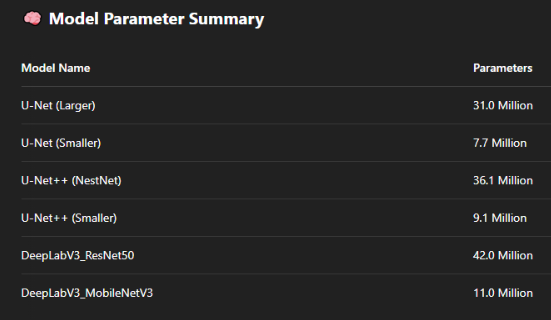

In [ ]:
import torch

# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters()) / 1e6
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad) / 1e6

# Display counts in millions
print(f"🧠 Total Parameters:     {total_params:.1f}M")
print(f"🛠️ Trainable Parameters: {trainable_params:.1f}M")
print()

## **🔄Training Loop + Num epochs**

In [ ]:
"""
Cell 15: ✅ Set input/output channels for segmentation based on food category

This cell ensures consistent variable naming across the entire project:
- Input channels are fixed to 3 (RGB), assigned to `in_channels` and `in_channel`
- Output channels depend on the selected food category, and are assigned consistently to:
  `out_channels`, `out_channel`, `num_classes`, and `num_class`
"""

# === Set input channels ===
in_channels = in_channel = 3  # RGB images

# === Set output channels based on food class ===
if selected_category == "AdasPolo":
    out_channels = out_channel = num_classes = num_class = 2  # Background + AdasPolo
elif selected_category in ["CheloGoosht", "Fesenjan", "GheymeBademjan", "Protein_and_Fries"]:
    out_channels = out_channel = num_classes = num_class = 3  # Background + 2 foregrounds
else:
    raise ValueError(f"❌ Unknown food category: {selected_category}")

# === Confirm final config ===
print("✅ Configuration Set")
print(f"in_channels   = {in_channels}")
print(f"in_channel    = {in_channel} ")
print(f"out_channels  = {out_channels}")
print(f"out_channel   = {out_channel}")
print(f"num_classes   = {num_classes}")
print(f"num_class     = {num_class}")
print(f"🔎 Category    = {selected_category}")

print("")
print(f"Initial LR is {lr}")


In [ ]:
# macro    => unweighted
# weighted => weighted

In [ ]:
num_epochs = 25

In [ ]:
"""
====================================================================================
🔁 Epoch-wise Training Loop with DPA Integration
====================================================================================

This loop performs epoch-wise training and validation for a segmentation model.
It tracks and prints key metrics, emphasizing **weighted metrics**, as they better
reflect real-world proportional relevance in tasks like food waste estimation.

Metrics included:
- Pixel Accuracy (macro & weighted)
- IoU (macro & weighted)
- Dice (macro & weighted)
- DPA (macro & weighted)
- Cross-entropy loss
====================================================================================
"""

print("📌 Note: In this task, **weighted metrics** are prioritized due to their relevance to class distribution.")
print("Macro metrics are reported for completeness, but are not significant to the evaluation logic.\n")

for epoch in range(num_epochs):
    print(f"🧪 Epoch {epoch + 1}/{num_epochs}")

    # Train and validate (now with num_classes)
    train_loss, train_pixel_acc_macro, train_pixel_acc_weighted, train_dice_macro, train_dice_weighted, train_iou_macro, train_iou_weighted, train_dpa_macro, train_dpa_weighted = train_one_epoch(
        model, train_loader, loss_function, optimizer, num_classes)

    valid_loss, valid_pixel_acc_macro, valid_pixel_acc_weighted, valid_dice_macro, valid_dice_weighted, valid_iou_macro, valid_iou_weighted, valid_dpa_macro, valid_dpa_weighted = valid_one_epoch(
        model, valid_loader, loss_function, num_classes)

    # Append training history
    train_pixel_accuracy_macro_history.append(train_pixel_acc_macro)
    train_pixel_accuracy_weighted_history.append(train_pixel_acc_weighted)
    train_dice_macro_history.append(train_dice_macro)
    train_dice_weighted_history.append(train_dice_weighted)
    train_iou_macro_history.append(train_iou_macro)
    train_iou_weighted_history.append(train_iou_weighted)
    train_dpa_macro_history.append(train_dpa_macro)
    train_dpa_weighted_history.append(train_dpa_weighted)
    train_loss_history.append(train_loss)

    # Append validation history
    valid_pixel_accuracy_macro_history.append(valid_pixel_acc_macro)
    valid_pixel_accuracy_weighted_history.append(valid_pixel_acc_weighted)
    valid_dice_macro_history.append(valid_dice_macro)
    valid_dice_weighted_history.append(valid_dice_weighted)
    valid_iou_macro_history.append(valid_iou_macro)
    valid_iou_weighted_history.append(valid_iou_weighted)
    valid_dpa_macro_history.append(valid_dpa_macro)
    valid_dpa_weighted_history.append(valid_dpa_weighted)
    valid_loss_history.append(valid_loss)

    # Print metrics for this epoch
    print("✅ Weighted Metrics (Key focus in this study):")
    print(f"Train - LOSS: {train_loss:.4f} , PixelAcc: {train_pixel_acc_weighted:.4f}, IoU: {train_iou_weighted:.4f}, Dice: {train_dice_weighted:.4f}, DPA: {train_dpa_weighted:.4f}")
    print(f"Valid - LOSS: {valid_loss:.4f} , PixelAcc: {valid_pixel_acc_weighted:.4f}, IoU: {valid_iou_weighted:.4f}, Dice: {valid_dice_weighted:.4f}, DPA: {valid_dpa_weighted:.4f}\n")

    print("📊 Macro Metrics (Reported, but not prioritized):")
    print(f"Train - PixelAcc: {train_pixel_acc_macro:.4f}, IoU: {train_iou_macro:.4f}, Dice: {train_dice_macro:.4f}, DPA: {train_dpa_macro:.4f}")
    print(f"Valid - PixelAcc: {valid_pixel_acc_macro:.4f}, IoU: {valid_iou_macro:.4f}, Dice: {valid_dice_macro:.4f}, DPA: {valid_dpa_macro:.4f}\n")

    # Print learning rate
    current_lr = optimizer.param_groups[0]['lr']
    print(f"📉 Learning Rate: {current_lr:.6f}\n")

    # Best-model tracking
    if valid_pixel_acc_macro > best_pixel_accuracy_macro:
        best_pixel_accuracy_macro = valid_pixel_acc_macro
        best_epoch_pixel_accuracy_macro = epoch + 1
        best_model_pixel_accuracy_macro = model.state_dict()

    if valid_pixel_acc_weighted > best_pixel_accuracy_weighted:
        best_pixel_accuracy_weighted = valid_pixel_acc_weighted
        best_epoch_pixel_accuracy_weighted = epoch + 1
        best_model_pixel_accuracy_weighted = model.state_dict()

    if valid_dice_macro > best_dice_macro:
        best_dice_macro = valid_dice_macro
        best_epoch_dice_macro = epoch + 1
        best_model_dice_macro = model.state_dict()

    if valid_dice_weighted > best_dice_weighted:
        best_dice_weighted = valid_dice_weighted
        best_epoch_dice_weighted = epoch + 1
        best_model_dice_weighted = model.state_dict()

    if valid_iou_macro > best_iou_macro:
        best_iou_macro = valid_iou_macro
        best_epoch_iou_macro = epoch + 1
        best_model_iou_macro = model.state_dict()

    if valid_iou_weighted > best_iou_weighted:
        best_iou_weighted = valid_iou_weighted
        best_epoch_iou_weighted = epoch + 1
        best_model_iou_weighted = model.state_dict()

    if valid_dpa_macro > best_dpa_macro:
        best_dpa_macro = valid_dpa_macro
        best_epoch_dpa_macro = epoch + 1
        best_model_dpa_macro = model.state_dict()

    if valid_dpa_weighted > best_dpa_weighted:
        best_dpa_weighted = valid_dpa_weighted
        best_epoch_dpa_weighted = epoch + 1
        best_model_dpa_weighted = model.state_dict()

    if valid_loss < best_loss:
        best_loss = valid_loss
        best_epoch_loss = epoch + 1
        best_model_loss = model.state_dict()

    # 🔁 Step the learning rate scheduler
    scheduler.step()  # ✅ Correct!



## **🔎 Performance Evaluation (based on Validation!)**

### Epoch based

In [ ]:
# ======================================================================================
# 📊 Summary of Best Validation Metrics (After Training)
# Note: These are based on validation performance, not training
# ======================================================================================

# Pixel Accuracy
print(f"Best Pixel Accuracy (Macro):      {best_pixel_accuracy_macro:.4f}       at Epoch    {best_epoch_pixel_accuracy_macro}")
print(f"Best Pixel Accuracy (Weighted):   {best_pixel_accuracy_weighted:.4f}    at Epoch    {best_epoch_pixel_accuracy_weighted}")
print("")

# IoU
print(f"Best IoU (Macro):                 {best_iou_macro:.4f}                  at Epoch    {best_epoch_iou_macro}")
print(f"Best IoU (Weighted):              {best_iou_weighted:.4f}               at Epoch    {best_epoch_iou_weighted}")
print("")

# Dice Coefficient
print(f"Best Dice Coefficient (Macro):    {best_dice_macro:.4f}                at Epoch    {best_epoch_dice_macro}")
print(f"Best Dice Coefficient (Weighted): {best_dice_weighted:.4f}             at Epoch    {best_epoch_dice_weighted}")
print("")

# DPA – Distributional Pixel Agreement
print(f"Best DPA (Macro):                 {best_dpa_macro:.4f}                  at Epoch    {best_epoch_dpa_macro}")
print(f"Best DPA (Weighted):              {best_dpa_weighted:.4f}               at Epoch    {best_epoch_dpa_weighted}")
print("")

# Loss
print(f"Best (Least) Cross-Entropy Loss:  {best_loss:.4f}                      at Epoch    {best_epoch_loss}")
print("=====================================================================================\n")


### Graph based

#### Pixel ACC

In [ ]:
# ======================================
# Pixel Accuracy Plot (Macro & Weighted)
# ======================================
min_len_pa = min(len(train_pixel_accuracy_weighted_history), len(valid_pixel_accuracy_weighted_history),
                 len(train_pixel_accuracy_macro_history), len(valid_pixel_accuracy_macro_history))
epochs_range_pa = range(min_len_pa)

fig, axs = plt.subplots(1, 2, figsize=(18, 6))

axs[0].plot(epochs_range_pa, [x.cpu().numpy() for x in train_pixel_accuracy_weighted_history[:min_len_pa]], 'o-', color='green', label='Train Pixel Accuracy (Weighted)')
axs[0].plot(epochs_range_pa, [x.cpu().numpy() for x in valid_pixel_accuracy_weighted_history[:min_len_pa]], 's-', color='red', label='Valid Pixel Accuracy (Weighted)')
axs[0].set_title('Weighted Pixel Accuracy Over Epochs')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Weighted Pixel Accuracy')
axs[0].set_yticks([i * 0.1 for i in range(11)])
axs[0].set_xticks(epochs_range_pa)
axs[0].legend()
axs[0].grid(True)

axs[1].plot(epochs_range_pa, [x.cpu().numpy() for x in train_pixel_accuracy_macro_history[:min_len_pa]], 'o-', color='blue', label='Train Pixel Accuracy (Macro)')
axs[1].plot(epochs_range_pa, [x.cpu().numpy() for x in valid_pixel_accuracy_macro_history[:min_len_pa]], 's-', color='orange', label='Valid Pixel Accuracy (Macro)')
axs[1].set_title('Macro Pixel Accuracy Over Epochs')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Macro Pixel Accuracy')
axs[1].set_yticks([i * 0.1 for i in range(11)])
axs[1].set_xticks(epochs_range_pa)
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

#### IoU

In [ ]:

# ==========================
# IoU Plot (Macro & Weighted)
# ==========================
min_len_iou = min(len(train_iou_weighted_history), len(valid_iou_weighted_history),
                  len(train_iou_macro_history), len(valid_iou_macro_history))
epochs_range_iou = range(min_len_iou)

fig, axs = plt.subplots(1, 2, figsize=(18, 6))

axs[0].plot(epochs_range_iou, [x.cpu().numpy() for x in train_iou_weighted_history[:min_len_iou]], 'o-', color='green', label='Train IoU (Weighted)')
axs[0].plot(epochs_range_iou, [x.cpu().numpy() for x in valid_iou_weighted_history[:min_len_iou]], 's-', color='red', label='Valid IoU (Weighted)')
axs[0].set_title('Weighted IoU Over Epochs')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Weighted IoU')
axs[0].set_yticks([i * 0.1 for i in range(11)])
axs[0].set_xticks(epochs_range_iou)
axs[0].legend()
axs[0].grid(True)

axs[1].plot(epochs_range_iou, [x.cpu().numpy() for x in train_iou_macro_history[:min_len_iou]], 'o-', color='blue', label='Train IoU (Macro)')
axs[1].plot(epochs_range_iou, [x.cpu().numpy() for x in valid_iou_macro_history[:min_len_iou]], 's-', color='orange', label='Valid IoU (Macro)')
axs[1].set_title('Macro IoU Over Epochs')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Macro IoU')
axs[1].set_yticks([i * 0.1 for i in range(11)])
axs[1].set_xticks(epochs_range_iou)
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

#### Dice

In [ ]:

# =============================
# Dice Plot (Macro & Weighted)
# =============================
min_len_dice = min(len(train_dice_weighted_history), len(valid_dice_weighted_history),
                   len(train_dice_macro_history), len(valid_dice_macro_history))
epochs_range_dice = range(min_len_dice)

fig, axs = plt.subplots(1, 2, figsize=(18, 6))

axs[0].plot(epochs_range_dice, [x.cpu().numpy() for x in train_dice_weighted_history[:min_len_dice]], 'o-', color='green', label='Train Dice (Weighted)')
axs[0].plot(epochs_range_dice, [x.cpu().numpy() for x in valid_dice_weighted_history[:min_len_dice]], 's-', color='red', label='Valid Dice (Weighted)')
axs[0].set_title('Weighted Dice Coefficient Over Epochs')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Weighted Dice')
axs[0].set_yticks([i * 0.1 for i in range(11)])
axs[0].set_xticks(epochs_range_dice)
axs[0].legend()
axs[0].grid(True)

axs[1].plot(epochs_range_dice, [x.cpu().numpy() for x in train_dice_macro_history[:min_len_dice]], 'o-', color='blue', label='Train Dice (Macro)')
axs[1].plot(epochs_range_dice, [x.cpu().numpy() for x in valid_dice_macro_history[:min_len_dice]], 's-', color='orange', label='Valid Dice (Macro)')
axs[1].set_title('Macro Dice Coefficient Over Epochs')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Macro Dice')
axs[1].set_yticks([i * 0.1 for i in range(11)])
axs[1].set_xticks(epochs_range_dice)
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

#### LOSS

In [ ]:
# =================
# Loss Plot (Train & Valid)
# =================
min_len_loss = min(len(train_loss_history), len(valid_loss_history))
epochs_range_loss = range(min_len_loss)

plt.figure(figsize=(10, 6))
plt.plot(epochs_range_loss, train_loss_history[:min_len_loss], 'o-', color='blue', label='Train Loss')
plt.plot(epochs_range_loss, valid_loss_history[:min_len_loss], 's-', color='orange', label='Valid Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(epochs_range_loss)
plt.legend()
plt.grid()
plt.show()

#### DPA

In [ ]:

# ========================
# New Metric: DPA Plot
# ========================
min_len_dpa = min(len(train_dpa_weighted_history), len(valid_dpa_weighted_history),
                  len(train_dpa_macro_history), len(valid_dpa_macro_history))
epochs_range_dpa = range(min_len_dpa)

fig, axs = plt.subplots(1, 2, figsize=(18, 6))

axs[0].plot(epochs_range_dpa, [x.cpu().numpy() for x in train_dpa_weighted_history[:min_len_dpa]], 'o-', color='green', label='Train DPA (Weighted)')
axs[0].plot(epochs_range_dpa, [x.cpu().numpy() for x in valid_dpa_weighted_history[:min_len_dpa]], 's-', color='red', label='Valid DPA (Weighted)')
axs[0].set_title('Weighted DPA Over Epochs')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Weighted DPA')
axs[0].set_yticks([i * 0.1 for i in range(11)])
axs[0].set_xticks(epochs_range_dpa)
axs[0].legend()
axs[0].grid(True)

axs[1].plot(epochs_range_dpa, [x.cpu().numpy() for x in train_dpa_macro_history[:min_len_dpa]], 'o-', color='blue', label='Train DPA (Macro)')
axs[1].plot(epochs_range_dpa, [x.cpu().numpy() for x in valid_dpa_macro_history[:min_len_dpa]], 's-', color='orange', label='Valid DPA (Macro)')
axs[1].set_title('Macro DPA Over Epochs')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Macro DPA')
axs[1].set_yticks([i * 0.1 for i in range(11)])
axs[1].set_xticks(epochs_range_dpa)
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

### Visualization based

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Load the best model (based on Weighted IoU)
model.load_state_dict(best_model_iou_weighted)
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Get two batches from validation loader
dataiter = iter(valid_loader)
images1, masks1 = next(dataiter)
images2, masks2 = next(dataiter)

# Move to device
images1, masks1 = images1.to(device), masks1.to(device)
images2, masks2 = images2.to(device), masks2.to(device)

# Predict
with torch.no_grad():
    outputs1 = model(images1)
    outputs2 = model(images2)

predictions1 = torch.softmax(outputs1, dim=1).argmax(dim=1)
predictions2 = torch.softmax(outputs2, dim=1).argmax(dim=1)

# Convert to numpy
images_np1 = images1.cpu().numpy()
masks_np1 = masks1.cpu().numpy()
predictions_np1 = predictions1.cpu().numpy()

images_np2 = images2.cpu().numpy()
masks_np2 = masks2.cpu().numpy()
predictions_np2 = predictions2.cpu().numpy()

# Plotting
fig, axes = plt.subplots(nrows=4, ncols=10, figsize=(20, 9))

def plot_row(axes, row_idx, image, mask, prediction, col_offset=0):
    img_disp = image.transpose(1, 2, 0)
    img_disp = np.clip(img_disp, 0, 1)

    # Original image
    axes[row_idx, col_offset].imshow(img_disp)
    axes[row_idx, col_offset].axis('off')
    if row_idx == 0:
        axes[row_idx, col_offset].set_title('Original')

    # Ground truth
    axes[row_idx, col_offset + 1].imshow(mask.squeeze(), cmap='tab20', vmin=0, vmax=10)
    axes[row_idx, col_offset + 1].axis('off')
    if row_idx == 0:
        axes[row_idx, col_offset + 1].set_title('Ground Truth')

    # Prediction
    axes[row_idx, col_offset + 2].imshow(prediction.squeeze(), cmap='tab20', vmin=0, vmax=10)
    axes[row_idx, col_offset + 2].axis('off')
    if row_idx == 0:
        axes[row_idx, col_offset + 2].set_title('Prediction')

    # Overlay with Ground Truth
    mask_rgb = plt.cm.tab20(mask.squeeze() / 10)[:, :, :3]
    overlay_gt = 0.3 * img_disp + 0.7 * mask_rgb
    axes[row_idx, col_offset + 3].imshow(overlay_gt)
    axes[row_idx, col_offset + 3].axis('off')
    if row_idx == 0:
        axes[row_idx, col_offset + 3].set_title('Overlay (Ground Truth)')

    # Overlay with Prediction
    pred_rgb = plt.cm.tab20(prediction / 10)[:, :, :3]
    overlay_pred = 0.3 * img_disp + 0.7 * pred_rgb
    axes[row_idx, col_offset + 4].imshow(overlay_pred)
    axes[row_idx, col_offset + 4].axis('off')
    if row_idx == 0:
        axes[row_idx, col_offset + 4].set_title('Overlay (Prediction)')

# Plot first batch (left half)
for i in range(4):
    plot_row(axes, i, images_np1[i], masks_np1[i], predictions_np1[i], col_offset=0)

# Plot second batch (right half)
for i in range(4):
    plot_row(axes, i, images_np2[i], masks_np2[i], predictions_np2[i], col_offset=5)

plt.tight_layout()
plt.savefig("Validation_DATA_Visualization_Overlay_GroundTruth.png", dpi=800, bbox_inches='tight')
plt.show()


## **🔎✅Performance based on Test Data**

### Based on numbers

In [ ]:
# =========================== Cell: Evaluate Best Model on Test Data ===========================
"""
Evaluates the best saved model (based on weighted IoU) on the held-out test set,
reporting both weighted and macro metrics including Pixel Accuracy, IoU, Dice, and DPA.
"""

# Load the best model based on weighted IoU
model.load_state_dict(best_model_iou_weighted)
model.to(device)
model.eval()

# Initialize accumulators
pixel_acc_weighted_total = 0.0
iou_weighted_total = 0.0
dice_weighted_total = 0.0
dpa_weighted_total = 0.0

pixel_acc_macro_total = 0.0
iou_macro_total = 0.0
dice_macro_total = 0.0
dpa_macro_total = 0.0

total_samples = 0

# Evaluate on test set
with torch.no_grad():
    for images, masks in test_loader:
        images, masks = images.to(device), masks.to(device)

        if masks.dim() == 4 and masks.size(1) == 1:
            masks = masks.squeeze(1)
        masks = masks.long()

        outputs = model(images)
        preds = torch.softmax(outputs, dim=1).argmax(dim=1)

        batch_size = images.size(0)
        total_samples += batch_size

        # Weighted metrics
        pixel_acc_weighted_total += pixel_accuracy_weighted(preds, masks) * batch_size
        iou_weighted_total += iou_weighted(preds, masks) * batch_size
        dice_weighted_total += dice_weighted(preds, masks, num_classes) * batch_size
        dpa_weighted_total += dpa_weighted(preds, masks, num_classes) * batch_size

        # Macro metrics
        pixel_acc_macro_total += pixel_accuracy_macro(preds, masks) * batch_size
        iou_macro_total += iou_macro(preds, masks) * batch_size
        dice_macro_total += dice_macro(preds, masks, num_classes) * batch_size
        dpa_macro_total += dpa_macro(preds, masks, num_classes) * batch_size

# Compute averages
pixel_acc_weighted_test = pixel_acc_weighted_total / total_samples
iou_weighted_test = iou_weighted_total / total_samples
dice_weighted_test = dice_weighted_total / total_samples
dpa_weighted_test = dpa_weighted_total / total_samples

pixel_acc_macro_test = pixel_acc_macro_total / total_samples
iou_macro_test = iou_macro_total / total_samples
dice_macro_test = dice_macro_total / total_samples
dpa_macro_test = dpa_macro_total / total_samples

# Print final test metrics
print("📊 Final Test Evaluation with Best IoU-Weighted Model")
print("📌 Note: In this study, **weighted metrics** are prioritized due to class imbalance relevance.\n")

print(f"✅ Weighted  - Pixel Acc: {pixel_acc_weighted_test:.6f}, IoU: {iou_weighted_test:.6f}, Dice: {dice_weighted_test:.6f}, DPA: {dpa_weighted_test:.6f}")
print(f"📊 Macro     - Pixel Acc: {pixel_acc_macro_test:.6f}, IoU: {iou_macro_test:.6f}, Dice: {dice_macro_test:.6f}, DPA: {dpa_macro_test:.6f}")


### Based on Visualization

In [ ]:
# =========================== Cell 2: Visualize Segmentation on Test Data (with Dual Overlays) ===========================

import matplotlib.pyplot as plt
import numpy as np
import torch

# Load best model based on weighted IoU
model.load_state_dict(best_model_iou_weighted)
model.to(device)
model.eval()

# Get two batches from test_loader
dataiter = iter(test_loader)
images1, masks1 = next(dataiter)
images2, masks2 = next(dataiter)

# Move data to device
images1, masks1 = images1.to(device), masks1.to(device)
images2, masks2 = images2.to(device), masks2.to(device)

# Run inference
with torch.no_grad():
    outputs1 = model(images1)
    outputs2 = model(images2)

# Get predicted masks via argmax of softmax
preds1 = torch.softmax(outputs1, dim=1).argmax(dim=1)
preds2 = torch.softmax(outputs2, dim=1).argmax(dim=1)

# Convert to NumPy arrays
images_np1 = images1.cpu().numpy()
masks_np1 = masks1.cpu().numpy()
preds_np1 = preds1.cpu().numpy()

images_np2 = images2.cpu().numpy()
masks_np2 = masks2.cpu().numpy()
preds_np2 = preds2.cpu().numpy()

# Plotting: 4 rows × 10 columns (5 plots per sample × 2 batches)
fig, axes = plt.subplots(4, 10, figsize=(22, 9))

# Plot function with dual overlays
def plot_row(axs, row_idx, image, mask, pred, col_offset=0):
    img_disp = image.transpose(1, 2, 0)
    img_disp = np.clip(img_disp, 0, 1)

    # Original
    axs[row_idx, col_offset].imshow(img_disp)
    axs[row_idx, col_offset].axis('off')
    if row_idx == 0:
        axs[row_idx, col_offset].set_title('Original')

    # Ground Truth Mask
    axs[row_idx, col_offset + 1].imshow(mask.squeeze(), cmap='tab20', vmin=0, vmax=num_classes - 1)
    axs[row_idx, col_offset + 1].axis('off')
    if row_idx == 0:
        axs[row_idx, col_offset + 1].set_title('GT Mask')

    # Prediction Mask
    axs[row_idx, col_offset + 2].imshow(pred.squeeze(), cmap='tab20', vmin=0, vmax=num_classes - 1)
    axs[row_idx, col_offset + 2].axis('off')
    if row_idx == 0:
        axs[row_idx, col_offset + 2].set_title('Prediction')

    # Overlay with Ground Truth
    gt_rgb = plt.cm.tab20(mask.squeeze() / max(1, num_classes - 1))[:, :, :3]
    overlay_gt = 0.3 * img_disp + 0.7 * gt_rgb
    axs[row_idx, col_offset + 3].imshow(overlay_gt)
    axs[row_idx, col_offset + 3].axis('off')
    if row_idx == 0:
        axs[row_idx, col_offset + 3].set_title('Overlay (GT)')

    # Overlay with Prediction
    pred_rgb = plt.cm.tab20(pred.squeeze() / max(1, num_classes - 1))[:, :, :3]
    overlay_pred = 0.3 * img_disp + 0.7 * pred_rgb
    axs[row_idx, col_offset + 4].imshow(overlay_pred)
    axs[row_idx, col_offset + 4].axis('off')
    if row_idx == 0:
        axs[row_idx, col_offset + 4].set_title('Overlay (Pred)')

# Plot batch 1 (columns 0–4)
for i in range(4):
    plot_row(axes, i, images_np1[i], masks_np1[i], preds_np1[i], col_offset=0)

# Plot batch 2 (columns 5–9)
for i in range(4):
    plot_row(axes, i, images_np2[i], masks_np2[i], preds_np2[i], col_offset=5)

plt.tight_layout()
plt.savefig("TEST_DATA_Visualization_Overlay_GroundTruth.png", dpi=800, bbox_inches='tight')
plt.show()